# Library

In [409]:
# My library
from molgraph.dataset import *
from molgraph.graphmodel import *
from molgraph.training import *
from molgraph.testing import *
from molgraph.visualize import *
from molgraph.interpret import *
from molgraph.experiment import *
from molgraph.fragmentation import *
# General library
import argparse
import numpy as np
import os
# scipy
from scipy.stats import mannwhitneyu
# pytorch
import torch
import pytorch_lightning as pl
# rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors 
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG=True
from matplotlib.pyplot import figure

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Argument

In [410]:
parser = ArgumentParser()
args = parser.getArgument('''
--file bbbp
--model GIN
--schema AR_0
--reduced functional
--mol_embedding 256
--batch_normalize
--fold 5
'''.split())

args

Namespace(batch_normalize=True, batch_size=256, class_number=1, device=device(type='cpu'), dropout=0.4, edge_dim=32, experiment_number='001', file='t01_amesmutagenicity_6512', fold=5, gpu=-1, grad_norm=1.0, graphtask='classification', heads=1, hidden_channels=256, in_channels=256, lr=5e-05, lr_schedule=True, model='GIN', mol_embedding=256, num_epochs=300, num_layers=3, num_layers_reduced=3, num_layers_self=3, num_layers_self_reduced=3, out_channels=256, patience=30, reduced=['pharmacophore'], schema='AR_0', seed=42, smiles='Canonical_Smiles', splitting='random', splitting_seed=42, task='Activity', vocab_len=100, weight_decay=5e-05)

# Dataset

In [411]:
file = args.file
smiles = args.smiles 
task = args.task
splitting = args.splitting 
splitting_fold = args.fold
splitting_seed = args.splitting_seed

# get validated dataset
datasets = getDataset(file, smiles, task, splitting)
# compute positive weight for classification
if args.graphtask == 'classification':
    args.pos_weight = getPosWeight(datasets)
    print('pos_weight:', args.pos_weight)
# generate dataset splitting
datasets_splitted = generateDatasetSplitting(file, splitting, splitting_fold, splitting_seed)
# generate all graph dataset
datasets_graph = generateGraphDataset(file)
# generate all reduced graph dataset
dict_reducedgraph = dict()
for g in args.reduced:
    if g == 'substructure':
        for i in range(splitting_fold):
            vocab_file = file+'_'+str(i)
            if not os.path.exists('vocab/'+vocab_file+'.txt'):
                generateVocabTrain(file, splitting_seed, splitting_fold, vocab_len=args.vocab_len)
            dict_reducedgraph[g] = generateReducedGraphDict(file, g, vocab_file=vocab_file)
    else:
        dict_reducedgraph[g] = generateReducedGraphDict(file, g)

Function: getDataset()
number of valid smiles: 6506
pos_weight: 0.8604518158421505
Function: generateDatasetSplitting()
Fold: 5
Fold Number: 0
-- Datasets Train: 4164
-- Datasets Val: 1040
-- Datasets Test:  1302
-- Total: 6506
Fold Number: 1
-- Datasets Train: 4163
-- Datasets Val: 1041
-- Datasets Test:  1302
-- Total: 6506
Fold Number: 2
-- Datasets Train: 4163
-- Datasets Val: 1041
-- Datasets Test:  1302
-- Total: 6506
Fold Number: 3
-- Datasets Train: 4163
-- Datasets Val: 1041
-- Datasets Test:  1302
-- Total: 6506
Fold Number: 4
-- Datasets Train: 4163
-- Datasets Val: 1041
-- Datasets Test:  1302
-- Total: 6506
Function: generateGraphDataset()
Datasets graph:  6505


In [412]:
args_test = dict()

# Load model
ts = "2023-Apr-10-16:47:07"
reduced_list = '_'.join(args.reduced)
args_test['log_folder_name'] = os.path.join(*[args.file, args.model+'_'+args.schema+'_'+reduced_list, f"{ts}"])
args_test['exp_name'] = args.experiment_number
args_test['fold_number'] = 4
args_test['seed'] = args.seed

In [413]:
training_bin = torch.load('./dataset/'+args_test['log_folder_name']+'/checkpoints/training_args.bin')

args.batch_size = training_bin.batch_size
args.num_layers = training_bin.num_layers
args.num_layers_reduced = training_bin.num_layers_reduced
args.in_channels = training_bin.in_channels
args.hidden_channels = training_bin.hidden_channels
args.out_channels = training_bin.out_channels
args.edge_dim = training_bin.edge_dim
args.num_layers_self = training_bin.num_layers_self
args.num_layers_self_reduced = training_bin.num_layers_self_reduced
args.dropout = training_bin.dropout
args.lr = training_bin.lr
args.weight_decay = training_bin.weight_decay


args

Namespace(batch_normalize=True, batch_size=16, class_number=1, device=device(type='cpu'), dropout=0.4, edge_dim=32, experiment_number='001', file='t01_amesmutagenicity_6512', fold=5, gpu=-1, grad_norm=1.0, graphtask='classification', heads=1, hidden_channels=128, in_channels=128, lr=5e-05, lr_schedule=True, model='GIN', mol_embedding=256, num_epochs=300, num_layers=2, num_layers_reduced=3, num_layers_self=3, num_layers_self_reduced=4, out_channels=128, patience=30, pos_weight=0.8604518158421505, reduced=['pharmacophore'], schema='AR_0', seed=42, smiles='Canonical_Smiles', splitting='random', splitting_seed=42, task='Activity', vocab_len=100, weight_decay=5e-05)

# Function

In [414]:
# from fragmentation.py

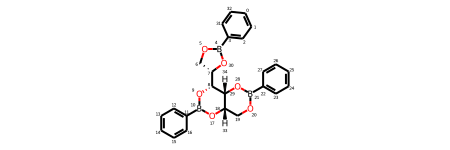

c1ccc(B2OC[C@@H]([C@H]3OB(c4ccccc4)O[C@H]4COB(c5ccccc5)O[C@H]43)O2)cc1
439.8780000000002


In [415]:
# mol = smiles_to_mol('CCCC(=O)/N=c1\sn(C(=O)CCC)c2ccc([N+](=O)[O-])cc12',with_atom_index=False)
mol = smiles_to_mol('c1ccc(B2OC[C@@H]([C@H]3OB(c4ccccc4)O[C@H]4COB(c5ccccc5)O[C@H]43)O2)cc1', with_atom_index=False)
# mol = smiles_to_mol('O=[N+]([O-])c1c(Cl)cc2c(c1Cl)Oc1cc(Cl)c(Cl)cc1O2', with_atom_index=False)
# mol = smiles_to_mol('c1ccc2c3c4c(cc5ccccc5c4cc2c1)C1=C3CCCC1', with_atom_index=False)
# mol = smiles_to_mol('CS(=O)(=O)Nc1ccc(Nc2c3ccc(N=[N+]=[N-])cc3nc3ccc(N=[N+]=[N-])cc23)cc1', with_atom_index=False)
display(mol)
print(Chem.MolToSmiles(mol))
print(Descriptors.MolWt(mol))

In [416]:
recap_frag = recap_frag_smiles_children([mol],limit=[0,100])
print(recap_frag)
len(recap_frag)
try:
    Draw.MolsToGridImage([Chem.MolFromSmiles(f) for f in recap_frag], subImgSize=(150,150), molsPerRow=10)
except Exception as e:
    print(e)

set()
not well-formed (invalid token): line 1, column 1


In [417]:
brics_frag = brics_frag_smiles([mol],limit=[5,100])
print(brics_frag)
len(brics_frag)
try:
    Draw.MolsToGridImage([Chem.MolFromSmiles(f) for f in brics_frag], subImgSize=(150,150), molsPerRow=10)
except Exception as e:
    print(e)

{'C1OB(c2ccccc2)OC2C1OB(c1ccccc1)OC2C1COB(c2ccccc2)O1'}


In [418]:
grinder_frag = grinder_frag_smiles([mol])
display(grinder_frag)
len(grinder_frag)
try:
    Draw.MolsToGridImage([Chem.MolFromSmiles(f) for f in grinder_frag], subImgSize=(150,150), molsPerRow=10)
except Exception as e:
    print(e)

{'*~B1OC(~*)C2OB(~*)OCC2O1',
 '*~B1OCC(~*)O1',
 '*~B1OCC2OB(c3ccccc3)OC(~*)C2O1',
 '*~C1COB(c2ccccc2)O1',
 '*~C1OB(c2ccccc2)OC2COB(c3ccccc3)OC12',
 '*~c1ccccc1'}

# Create fragment dict

In [420]:
fragment_dict = dict()
no_fragment = list()
path = 'dataset/'+file+'/fragment.pickle'

if os.path.exists(path):
    with open(path, 'rb') as handle:
        fragment_dict = pickle.load(handle)
else:
    for g in tqdm(datasets_graph):
        mol = smiles_to_mol(g, with_atom_index=False, kekulize=False)
        limit = [3,20] # 3-20 atoms
        fragment_recap = recap_frag_smiles_children([mol], limit=limit)
        fragment_brics = brics_frag_smiles([mol], limit=limit)
        fragment_grinder = grinder_frag_smiles([mol], limit=limit)
        fragment_all_t = fragment_recap.union(fragment_brics)
        fragment_all = fragment_all_t.union(fragment_grinder)
        fragment_dict[g] = fragment_all
        if len(fragment_all) == 0:
            no_fragment.append(g)
        # break
    
    # write dataset to pickle 
    with open(path, 'wb') as handle:
        pickle.dump(fragment_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print('fragment_dict', len(fragment_dict))
print('no_fragment', len(no_fragment))

fragment_dict 6505
no_fragment 0


# Test

In [421]:
# # test with dataset
# # test_loader, datasets_test =  generateDataLoaderTesting(datasets_graph[1], args.batch_size)
# # test_loader, datasets_test =  generateDataLoaderTesting([datasets_graph[1][360]], 1)
# test_loader, datasets_test =  generateDataLoaderTesting(args.file, 1)
# sample_to_test = datasets_test[2]
# test_loader, datasets_test =  generateDataLoaderListing([sample_to_test], 1)

# molecule_test = datasets_test[0]
# print(molecule_test)

In [422]:
# test with t = sample
smiles_sample = 'c1ccc2c3c4c(cc5ccccc5c4cc2c1)C1=C3CCCC1'
smiles_sample = 'C[C@H]1CC(=O)O1'
smiles_sample = 'CC(=O)NC1=CC(=C(C=C1[N+](=O)[O-])Cl)Cl'
smiles_sample = 'CS(=O)(=O)C1=CC(=C(C=C1)[N+](=O)[O-])NC2CC2'
smiles_sample = 'C1=CC=C(C=C1)S(=O)(=O)CCNC2=C(C=C(C=C2)S(=O)(=O)N)[N+](=O)[O-]'
smiles_processes = mol_to_smiles(smiles_to_mol(smiles_sample, with_atom_index=False))
mol_process = smiles_to_mol(smiles_processes, with_atom_index=False)
molecule_test = [constructGraph(smiles_processes, 3.5)]
test_loader = DataLoader(molecule_test, batch_size=1, shuffle=True, follow_batch=['x_g', 'x_r'])
molecule_test = molecule_test[0]
print(molecule_test)

PairData(smiles='NS(=O)(=O)c1ccc(NCCS(=O)(=O)c2ccccc2)c([N+](=O)[O-])c1', x_g=[25, 79], edge_index_g=[2, 52], edge_attr_g=[52, 10], y=[1, 1])


In [423]:
tester = Tester(args, args_test)
# tester.test(test_loader, return_attention_weights=True)
tester.test_single(test_loader, return_attention_weights=True)

GNN_Combine(
  (node_feature_graph): NodeLinear(
    (lin1): Linear(in_features=79, out_features=128, bias=True)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (edge_feature_graph): EdgeLinear(
    (lin1): Linear(in_features=10, out_features=32, bias=True)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (GNN_Graph): GNN_Graph(
    (convs): ModuleList(
      (0): GINEConv(nn=Sequential(
        (0): GIN_Sequential(
          (lin1): Linear(in_features=128, out_features=128, bias=True)
          (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (leakyrelu1): LeakyReLU(negative_slope=0.01)
          (lin2): Linear(in_features=128, out_features=128, bias=True)
        )
      ))
      (1): GINEConv(nn=Sequential(
        (0): GIN_Sequential(
          (lin1): Linear(in_features=128, out_features=128, bias=True)
          (bn1): BatchNorm1d(128, e

tensor([[False]])

In [424]:
# att = tester.getAttention()
att_mol = tester.getAttentionMol()
if 'atom' in att_mol:
    if len(args.reduced) >= 1:
        sample_att = (att_mol['atom'], att_mol[args.reduced[0]])
    else:
        sample_att = (att_mol['atom'], None)
else:
    sample_att = (None, att_mol[args.reduced[0]])
sample_graph = molecule_test

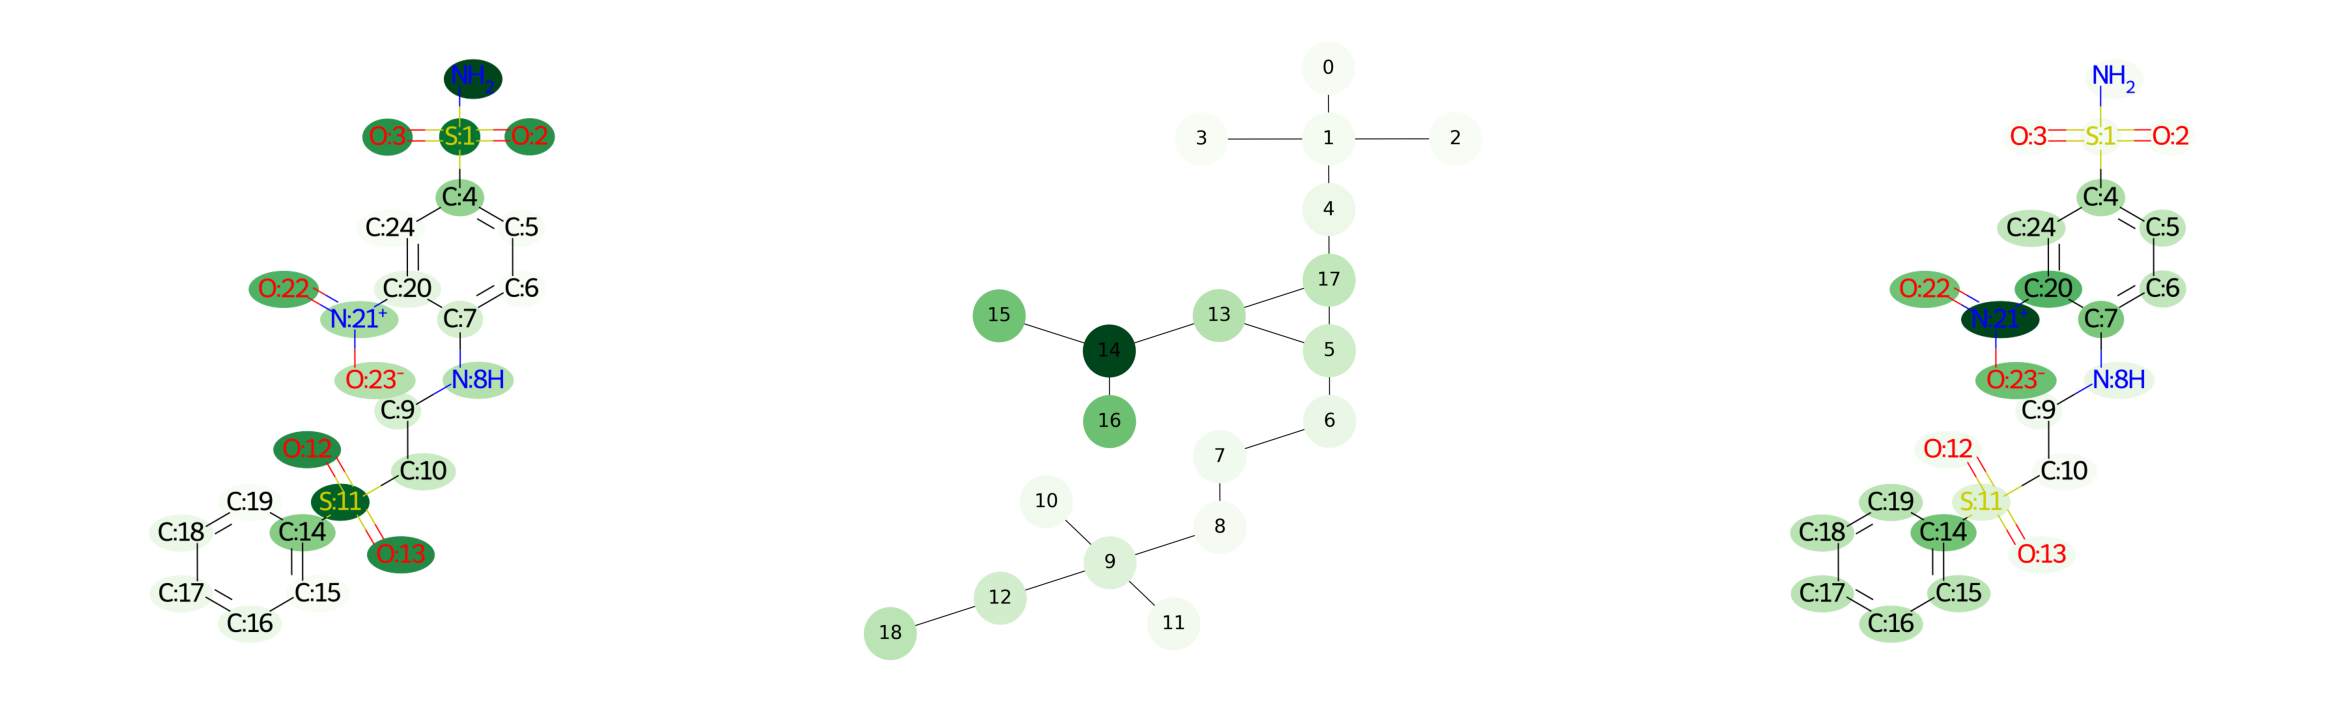

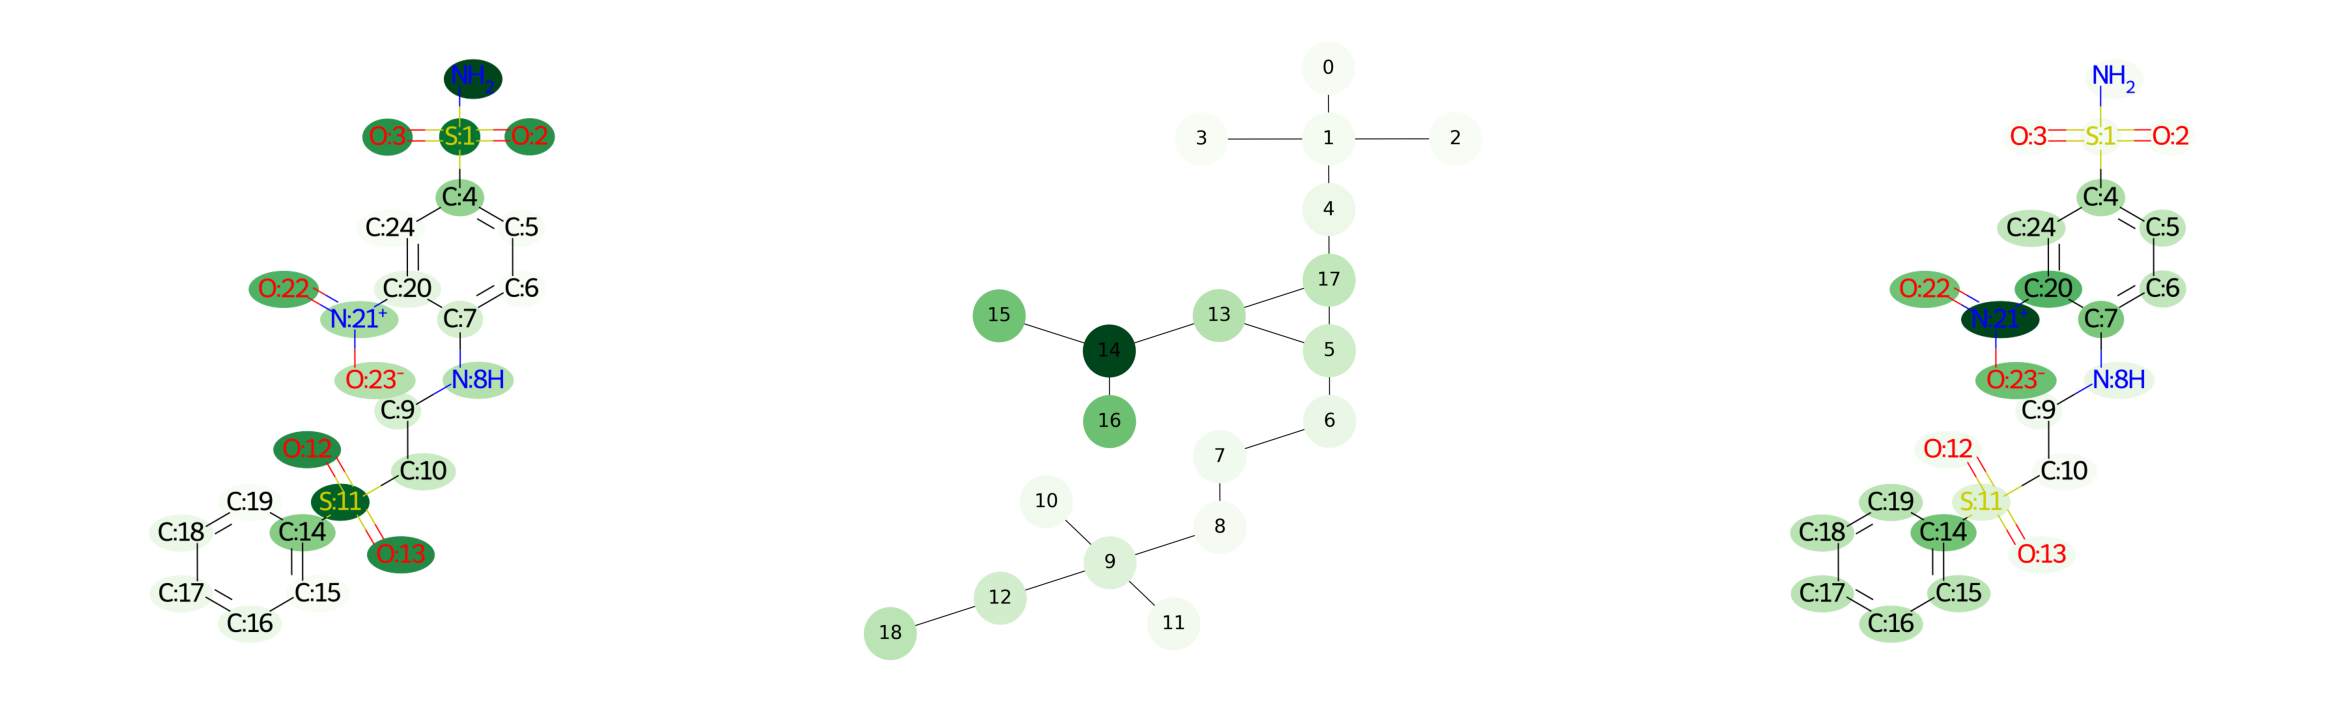

In [425]:
plot_attentions(args, sample_graph, sample_att)

mask_graph_g
{'atom': {0: 1.0, 1: 0.8458046486148955, 2: 0.7255582791306394, 3: 0.7255582791306394, 4: 0.41064307713208476, 5: 0.00637947532151939, 6: 0.0011505628025304526, 7: 0.1943163341732539, 8: 0.3158886822539392, 9: 0.17965328789014065, 10: 0.236896920587949, 11: 0.9136417259597461, 12: 0.7532051143505245, 13: 0.7532051143505245, 14: 0.4456181105758198, 15: 0.0037207777269044895, 16: 0.0846628903003927, 17: 0.07011188612366659, 18: 0.0846628903003927, 19: 0.0037207777269044895, 20: 0.1165323520906128, 21: 0.3545194814253106, 22: 0.5929645501406607, 23: 0.3146785912392231, 24: 0.0}, 'bond': {}}
mask_graph_r
{'atom': {0: 0.009669081770267318, 1: 0.027101069433586755, 2: 0.0, 3: 0.0, 4: 0.07212813709138827, 5: 0.21387493710551894, 6: 0.0934766174651794, 7: 0.046224614165670835, 8: 0.014830726948761447, 9: 0.15479062414777578, 10: 0.035232980987825374, 11: 0.035232980987825374, 12: 0.20968722614157653, 13: 0.31232710235194155, 14: 1.0, 15: 0.5102361243903998, 16: 0.5168055229726592,

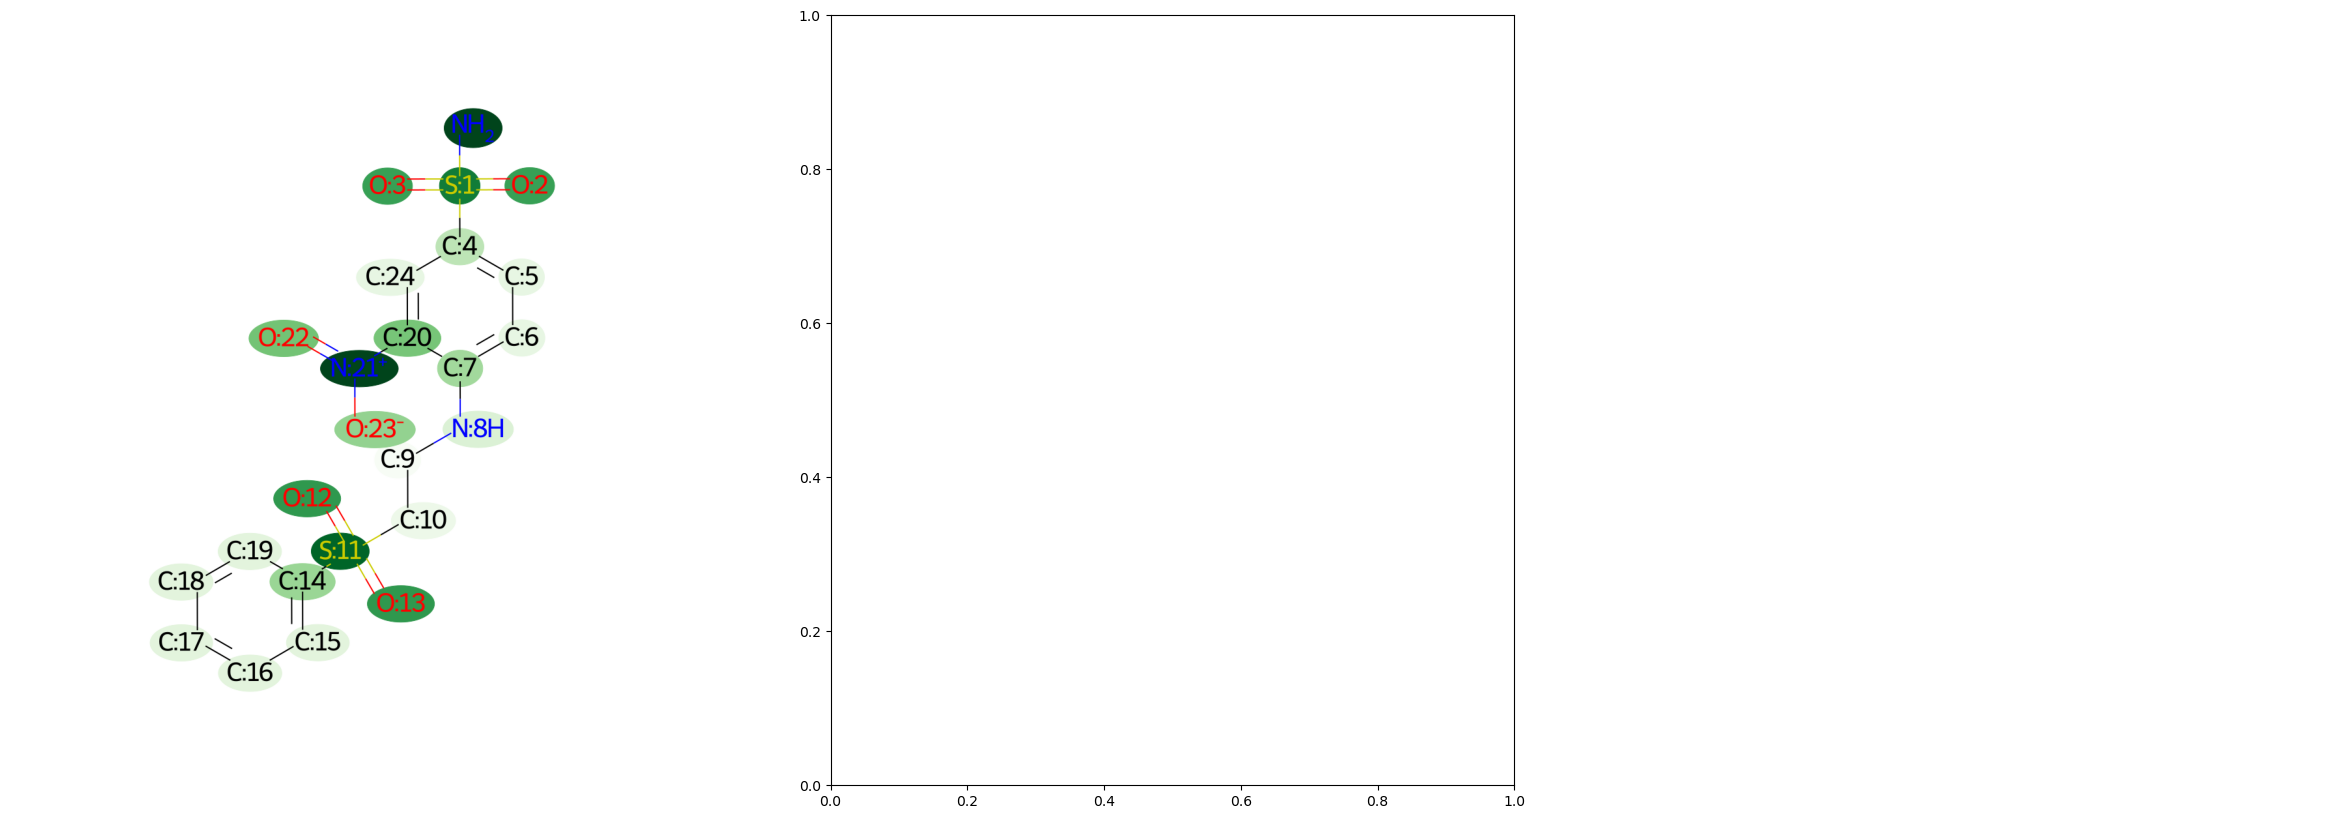

In [426]:
# attention result
att_mol = tester.getAttentionMol()
sample_att = att_mol
sample_graph = molecule_test
if 'atom' in sample_att:
    sample_att_g = sample_att['atom']
else:
    sample_att_g = None
if len(args.reduced) != 0:
    sample_att_r = sample_att[args.reduced[0]]
else:
    sample_att_r = None

# sample_att_g, sample_att_r = sample_att
if args.schema in ['A', 'R_N', 'AR', 'AR_0', 'AR_N']:
    mask_graph_g = mask_graph(sample_att_g)
    print('mask_graph_g')
    print(mask_graph_g)
if args.schema in ['R', 'R_0', 'R_N', 'AR', 'AR_0', 'AR_N']:
    mask_graph_r = mask_reduced(sample_att_r)
    print('mask_graph_r')
    print(mask_graph_r)

print(args.schema)
# record importance
mask_graph_x = None
# if args.schema in ['A']:
if 'A' in args.schema:
    mask_graph_x = mask_graph_g
    # reduced graph
    reduced_graph, cliques, edges = getReducedGraph(args, ['atom'], smiles_processes, normalize=False)
    
if 'R' in args.schema:
    mask_graph_x = mask_graph_r
    # reduced graph
    reduced_graph, cliques, edges = getReducedGraph(args, args.reduced, smiles_processes, normalize=False)
    if not args.schema in ['A']:
        mask_graph_x = mask_rtog(smiles_processes, cliques, mask_graph_r)
        print('mask_graph_x')
        print(mask_graph_x)
        if args.schema in ['AR', 'AR_0', 'AR_N']:
            mask_graph_x = mask_gandr(mask_graph_g, mask_graph_x)
    
    print(mask_graph_x)
    display_interpret_weight(mol_process, None, None, mask_graph_x, None, scale=True)


In [427]:
ff = [12,13,14]
attention_frag = list()
attention_nonfrag = list()
for i in mask_graph_x['atom']:
    if i in ff:
        attention_frag.append(mask_graph_x['atom'][i])
    else:
        attention_nonfrag.append(mask_graph_x['atom'][i])
# if np.sum(attention_frag+attention_nonfrag) != 0:
#     p = np.sum(attention_frag)/np.sum(attention_frag+attention_nonfrag)
# else:
#     p = 0
# p = np.average(attention_frag)
print(attention_frag)
p = np.median(attention_frag)
print('p', p)
# threshold = 0.5
threshold = np.percentile(attention_frag+attention_nonfrag, 70)
print('threshold', threshold)
print(p >= threshold)

U1, p = mannwhitneyu(attention_frag, attention_nonfrag, alternative = 'greater')
print("p-value", p)
print(attention_frag, attention_nonfrag)


[0.6991578292369323, 0.6991578292369323, 0.3917021797564979]
p 0.6991578292369323
threshold 0.6331301604253243
True
p-value 0.0962945280926572
[0.6991578292369323, 0.6991578292369323, 0.3917021797564979] [1.0, 0.8120363632731242, 0.6654564261450859, 0.6654564261450859, 0.2815758091452073, 0.10834488468875714, 0.10834488468875714, 0.3690577442008669, 0.16607050696090814, 0.0, 0.06977980389606575, 0.8947295420759986, 0.1360941264222199, 0.1360941264222199, 0.1360941264222199, 0.1360941264222199, 0.1360941264222199, 0.48907061655481643, 1.0, 0.5038250975462801, 0.4109874887111972, 0.10834488468875714]


## Running

In [428]:
all_dataset = datasets_graph
print('Number of dataset:', len(all_dataset))

Number of dataset: 6505


In [429]:
tester = Tester(args, args_test)

GNN_Combine(
  (node_feature_graph): NodeLinear(
    (lin1): Linear(in_features=79, out_features=128, bias=True)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (edge_feature_graph): EdgeLinear(
    (lin1): Linear(in_features=10, out_features=32, bias=True)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (GNN_Graph): GNN_Graph(
    (convs): ModuleList(
      (0): GINEConv(nn=Sequential(
        (0): GIN_Sequential(
          (lin1): Linear(in_features=128, out_features=128, bias=True)
          (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (leakyrelu1): LeakyReLU(negative_slope=0.01)
          (lin2): Linear(in_features=128, out_features=128, bias=True)
        )
      ))
      (1): GINEConv(nn=Sequential(
        (0): GIN_Sequential(
          (lin1): Linear(in_features=128, out_features=128, bias=True)
          (bn1): BatchNorm1d(128, e

In [430]:
# distribution
attention_distribution = list()
# score
feature_score = dict()

list_features = list()
attention_substructure = dict()

# count found substructure
count_substructure = dict()

# num substructure
num_substructure = dict()

# psub
psub_all = set()
psub_after = list()

count = 0 

count_1000 = list()
count_1 = list()

threshold_list = list()

for d in tqdm(all_dataset):

    # data loader
    test_loader, datasets_test =  generateDataLoaderListing([all_dataset[d]], 1)
    molecule_test = datasets_test[0]

    # molecule
    smiles_test = molecule_test.smiles
    mol_test = smiles_to_mol(smiles_test, with_atom_index=False, kekulize=False)
    if mol_test.GetNumAtoms() > 100:
        count_1000.append(smiles_test)
    #     continue

    # testing
    # print(datasets_test)
    try:
        predicted = tester.test_single(test_loader, return_attention_weights=True, print_result=False)
    except:
        predicted = None

    # if predicted != molecule_test.y:
    #     print(molecule_test.smiles, "TRUE:", molecule_test.y, "PREDICTED:", predicted)

    if predicted is not None:
        # print(predicted)
        try:
            predicted = predicted.item()
        except:
            predicted = predicted[0][0]

        # regression record as 1
        if args.graphtask == 'regression':
            predicted = 1

        if predicted not in attention_substructure:
            attention_substructure[predicted] = dict()
            count_substructure[predicted] = dict()
            num_substructure[predicted] = dict()
            feature_score[predicted] = dict()

        count += 1

        # attention result
        att_mol = tester.getAttentionMol()
        sample_att = att_mol
        sample_graph = molecule_test
        if 'atom' in sample_att:
            sample_att_g = sample_att['atom']
        else:
            sample_att_g = None
        if len(args.reduced) != 0:
            sample_att_r = sample_att[args.reduced[0]]
        else:
            sample_att_r = None
        # sample_att_g, sample_att_r = sample_att
        if args.schema in ['A', 'R_N', 'AR', 'AR_0', 'AR_N']:
            mask_graph_g = mask_graph(sample_att_g)
        if args.schema in ['R', 'R_0', 'R_N', 'AR', 'AR_0', 'AR_N']:
            mask_graph_r = mask_reduced(sample_att_r)

        # molecule
        smiles = sample_graph.smiles
        mol = smiles_to_mol(smiles, with_atom_index=False, kekulize=False)

        if smiles not in count_substructure[predicted]:
            count_substructure[predicted][smiles] = list()

        # record importance
        mask_graph_x = None
        # if args.schema in ['A']:
        if 'A' in args.schema:
            mask_graph_x = mask_graph_g

            # reduced graph
            reduced_graph, cliques, edges = getReducedGraph(args, ['atom'], smiles, normalize=False)

            # for i, f in enumerate(reduced_graph.node_features):
            #     # getImportanceFeatures
            #     f_tuple = getImportanceFeatures(['atom'], f)

            #     list_features.append(f_tuple)


        # elif args.schema in ['R', 'R_0', 'R_N', 'AR', 'AR_0', 'AR_N']:
        if 'R' in args.schema:
            mask_graph_x = mask_graph_r

            # reduced graph
            reduced_graph, cliques, edges = getReducedGraph(args, args.reduced, smiles, normalize=False)

            if not args.schema in ['A']:
                mask_graph_x = mask_rtog(smiles, cliques, mask_graph_r)
                if args.schema in ['AR', 'AR_0', 'AR_N']:
                    mask_graph_x = mask_gandr(mask_graph_g, mask_graph_x)

            # for i, f in enumerate(reduced_graph.node_features):
            #     # getImportanceFeatures
            #     if len(args.reduced) == 0:
            #         f_tuple = getImportanceFeatures(['atom'], f)
            #     elif 'substructure' not in args.reduced:
            #         f_tuple = getImportanceFeatures(args.reduced, f)
            #     else:
            #         f_tuple = getImportanceFeatures(args.reduced, reduced_graph.cliques_smiles[i])

            #     list_features.append(f_tuple)
        
        # distribution
        attention_distribution.append(list(mask_graph_x['atom'].values()))
        # average
        mol_avg = np.mean(list(mask_graph_x['atom'].values()))
            
        # get series of reasonable fragments
        # print(smiles)
        if smiles in fragment_dict:
            fragment_all = fragment_dict[smiles]
        else:
            limit = [3,20] # 3-20 atoms
            fragment_recap = recap_frag_smiles_children([mol], limit=limit)
            fragment_brics = brics_frag_smiles([mol], limit=limit)
            fragment_grinder = grinder_frag_smiles([mol], limit=limit)
            fragment_all_t = fragment_recap.union(fragment_brics)
            fragment_all = fragment_all_t.union(fragment_grinder)

        # print(fragment_all)
        if len(fragment_all) == 1:
            count_1.append(smiles)
            # print(smiles)

        frag_smarts_passed = list()

        threshold = None

        for frag in fragment_all:

            frag_smarts = frag
            frag_mol = Chem.MolFromSmarts(frag_smarts)

            frag_match = mol.GetSubstructMatches(frag_mol)
        
            # print(children_match)
            
            for ff in frag_match:
                attention_frag = list()
                attention_nonfrag = list()
                # print(ff)
                for i in mask_graph_x['atom']:
                    if i in ff:
                        attention_frag.append(mask_graph_x['atom'][i])
                    else:
                        attention_nonfrag.append(mask_graph_x['atom'][i])
                assert len(attention_frag) == len(ff)
                assert len(attention_frag)+len(attention_nonfrag) == len(mask_graph_x['atom'])
                try:
                    # if np.sum(attention_frag+attention_nonfrag) != 0:
                    #     p = np.sum(attention_frag)/np.sum(attention_frag+attention_nonfrag)
                    # else:
                    #     p = 0
                    # p = np.average(attention_frag)
                    p = np.median(attention_frag)
                    # threshold = 0.5
                    percentile_value = 75
                    if 't04' in args.file:
                        percentile_value = 70
                    threshold = np.percentile(attention_frag+attention_nonfrag, percentile_value)
                    
                    # U1, p = mannwhitneyu(attention_frag, attention_nonfrag, alternative = 'greater')
                    # print(p, attention_frag, attention_nonfrag)
                    if p >= threshold:
                        if frag_smarts in attention_substructure[predicted]:
                            attention_substructure[predicted][frag_smarts].append(smiles)
                        else:
                            attention_substructure[predicted][frag_smarts] = [smiles]
                        frag_smarts_passed.append(frag_smarts)
                        count_substructure[predicted][smiles].append(frag_smarts)

                    # score
                    f_avg = np.mean(attention_frag)
                    if frag_smarts in feature_score[predicted]:
                        feature_score[predicted][frag_smarts].append(f_avg-mol_avg)
                    else:
                        feature_score[predicted][frag_smarts] = [f_avg-mol_avg]

                except ValueError:
                    pass
            
                if frag_smarts not in num_substructure[predicted]:
                    num_substructure[predicted][frag_smarts] = [smiles]
                else:
                    num_substructure[predicted][frag_smarts].append(smiles)

                # print(attention_substructure)
                # display_interpret_weight(mol, cliques, edges, None, mask_graph_r, scale=True)
        
        if threshold is not None and predicted == 1: threshold_list.append(threshold) 
        
        psub_all.update(frag_smarts_passed)

print('count_1000', len(count_1000))
print('count_1', len(count_1))

100%|██████████| 6505/6505 [12:17<00:00,  8.82it/s]

count_1000 5
count_1 288


# Prediction number

In [431]:
print("0:", len(count_substructure[0]))
print("1:", len(count_substructure[1]))


0: 2592
1: 3913


In [432]:
print(len(psub_all))

14168


In [433]:
print(len(threshold_list), np.mean(threshold_list), np.std(threshold_list))

3704 0.6737434653410335 0.2064311133706282


In [434]:
# psub_all

# Score

In [435]:
predicted = 1
df_featurename = list()
df_featurescore = list()
for i in feature_score[predicted]:
    sum_score = np.sum(feature_score[predicted][i])
    score = sum_score/len(feature_score[predicted][i])
    df_featurename.append(i)
    df_featurescore.append(score)
df_score = pd.DataFrame({'fragment': df_featurename, 'score': df_featurescore}).sort_values(by='score', ascending=False).reset_index(drop=True)
display(df_score)

fragment     score
0           *~c1c[nH]cn1  0.423927
1          *~C=[N+]=[N-]  0.397933
2              *~C1NC1~*  0.397742
3              *~N(O)N=O  0.387821
4                *~SCCBr  0.384200
...                  ...       ...
113265  *~CCCS(~*)(~*)=O -0.339123
113266  *~CCCS(~*)(~*)~* -0.339123
113267   *~S(~*)(~*)CCCN -0.339123
113268   *~S(~*)(=O)CCCN -0.339123
113269         *~OCCCO~* -0.434349

[113270 rows x 2 columns]

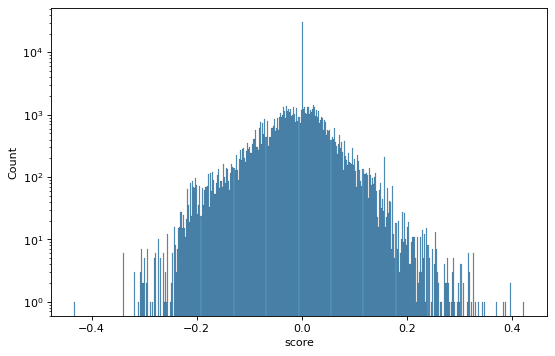

In [436]:
figure(figsize=(8, 5), dpi=80)
fig = sns.histplot(df_score['score'])
fig.set_yscale("log")

In [437]:
top10 = df_score[:10]
top10

fragment     score
0   *~c1c[nH]cn1  0.423927
1  *~C=[N+]=[N-]  0.397933
2      *~C1NC1~*  0.397742
3      *~N(O)N=O  0.387821
4        *~SCCBr  0.384200
5    *~OB(~*)O~*  0.370016
6    *~COB(~*)~*  0.347353
7    *~C=CCC=C~*  0.344936
8  *~N=[N+]=[N-]  0.336904
9       *~CSCCBr  0.330785

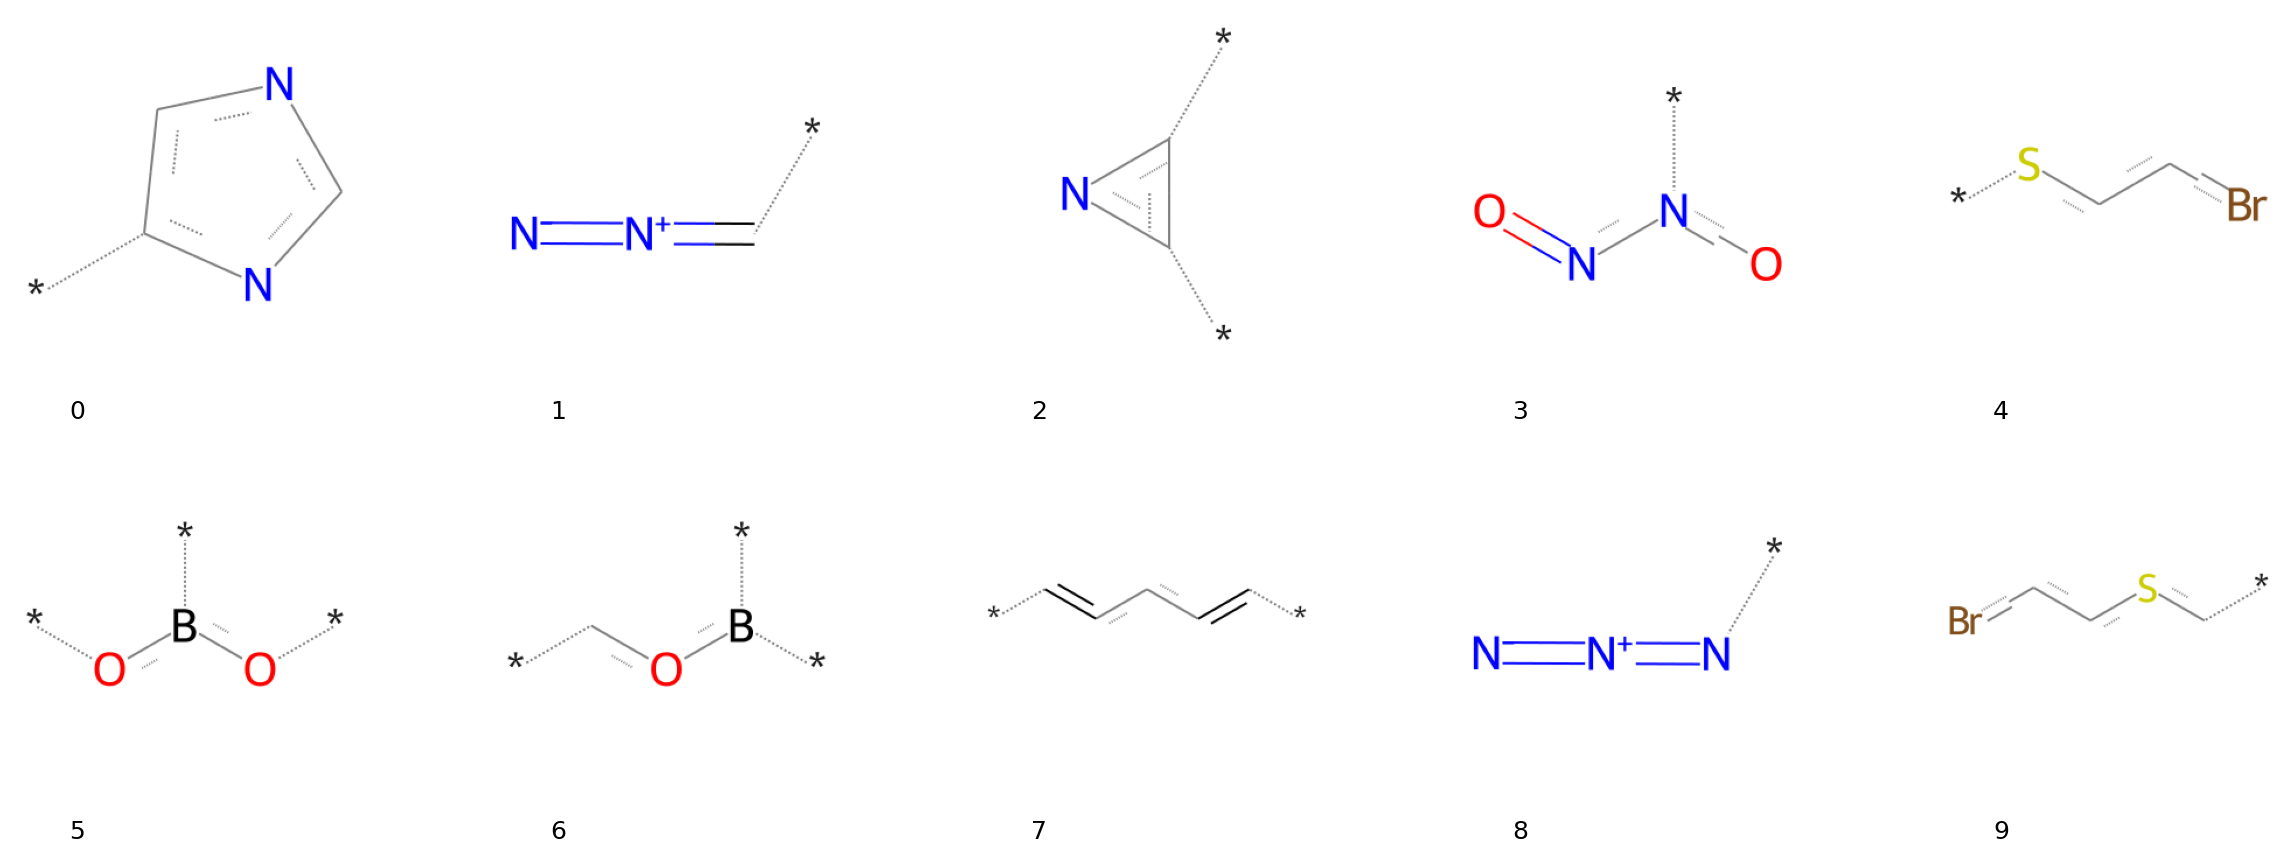

In [438]:
drawGridMolecule([Chem.MolFromSmarts(t) for t in top10['fragment']], labels=range(len(top10)))

# Attention Substructure

In [439]:
# Class 1
predicted = 1
att_0 = dict(sorted(attention_substructure[predicted].items(), key=lambda item: len(set(item[1])), reverse=True))
print(len(att_0))
for i, a in enumerate(att_0):
    if i < 10:
        print(a, len(att_0[a]), len(set(att_0[a])))
        # display(Chem.MolFromSmarts(a))
print('and more...')


3417
*~[N+](=O)[O-] 607 543
*~c1ccccc1 152 88
*~N(~*)N=O 78 78
*~C1CO1 69 64
*~N=[N+]=[N-] 64 60
*~c1ccc(~*)cc1 46 45
*~S(~*)(=O)=O 51 40
*~CC1CO1 40 38
*~CN=[N+]=[N-] 33 33
*~Cc1ccccc1 45 30
and more...


3417
One element fragments
Two element fragments


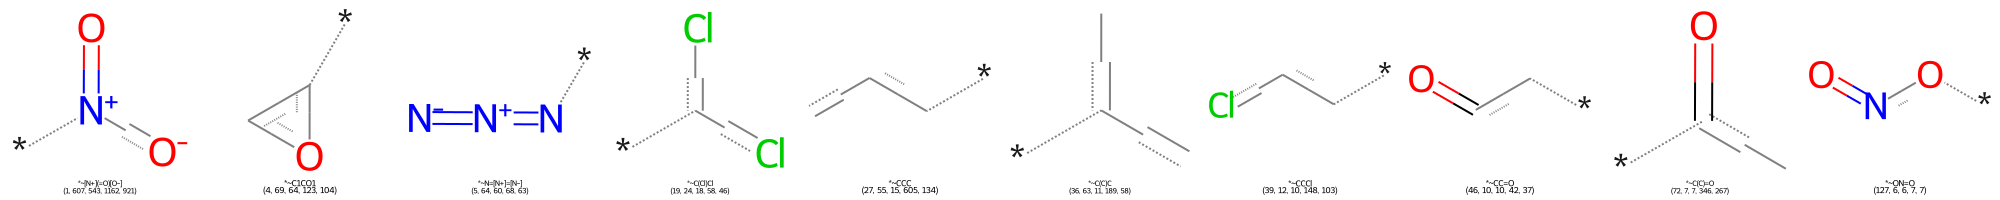

Three element fragments


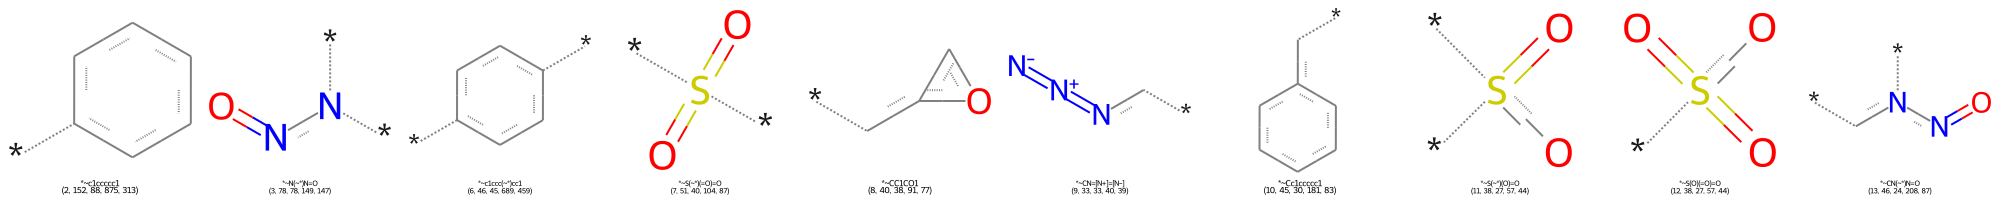

In [440]:
# Class 1
predicted = 1
sub_one = (list(), list(), list())
sub_two = (list(), list(), list())
sub_three = (list(), list(), list())
sub_all = (list(), list(), list())
limit = 10
att_1 = dict(sorted(attention_substructure[predicted].items(), key=lambda item: len(set(item[1])), reverse=True))
print(len(att_1))

for i, a in enumerate(att_1):
    # print(a, att_1[a])
    sub_mol = Chem.MolFromSmarts(a)
    sub_atom = sub_mol.GetNumAtoms()
    try:
        sub_mol_smiles = Chem.MolFromSmiles(a)
        Chem.Kekulize(sub_mol_smiles, clearAromaticFlags=True)
    except:
        if len(sub_all[0]) < 20:
            print('EXCEPT')
            print(a)
        # break
        # sub_mol_smiles = Chem.MolFromSmiles(smiles)
        # Chem.Kekulize(sub_mol_smiles, clearAromaticFlags=True)
        # continue
    # print(sub_atom)
    if sub_atom <= 3 and len(sub_one[0]) < limit:
        sub_one[0].append(a)
        sub_one[1].append(sub_mol)
        sub_one[2].append((i+1, len(att_1[a]), len(set(att_1[a])), len(num_substructure[predicted][a]), len(set(num_substructure[predicted][a]))))
    elif sub_atom == 4 and len(sub_two[0]) < limit:
        sub_two[0].append(a)
        sub_two[1].append(sub_mol)
        sub_two[2].append((i+1, len(att_1[a]), len(set(att_1[a])), len(num_substructure[predicted][a]), len(set(num_substructure[predicted][a]))))
    elif len(sub_three[0]) < limit:
        sub_three[0].append(a)
        sub_three[1].append(sub_mol)
        sub_three[2].append((i+1, len(att_1[a]), len(set(att_1[a])), len(num_substructure[predicted][a]), len(set(num_substructure[predicted][a]))))
    if len(sub_all[0]) < 50:
        sub_all[0].append(a)
        sub_all[1].append(sub_mol)
        sub_all[2].append((i+1, len(att_1[a]), len(set(att_1[a])), len(num_substructure[predicted][a]), len(set(num_substructure[predicted][a]))))
    # display(Chem.MolFromSmarts(a))


# IPythonConsole.drawOptions.addAtomIndices = False
print('One element fragments') # depending number of atoms
# display(Draw.MolsToImage(sub_one[1],legends=[s1+'\n'+str(s2) for s1, s2 in zip(sub_one[0],sub_one[2])]))
print('Two element fragments') # depending number of atoms
display(Draw.MolsToImage(sub_two[1],legends=[s1+'\n'+str(s2) for s1, s2 in zip(sub_two[0],sub_two[2])]))
print('Three element fragments') # depending number of atoms
display(Draw.MolsToImage(sub_three[1],legends=[s1+'\n'+str(s2) for s1, s2 in zip(sub_three[0],sub_three[2])]))
# print('Unlimited element fragments') # depending number of atoms
# display(Draw.MolsToGridImage(sub_all[1],legends=[s1+'\n'+str(s2) for s1, s2 in zip(sub_all[0],sub_all[2])], molsPerRow=5))

Three element fragments


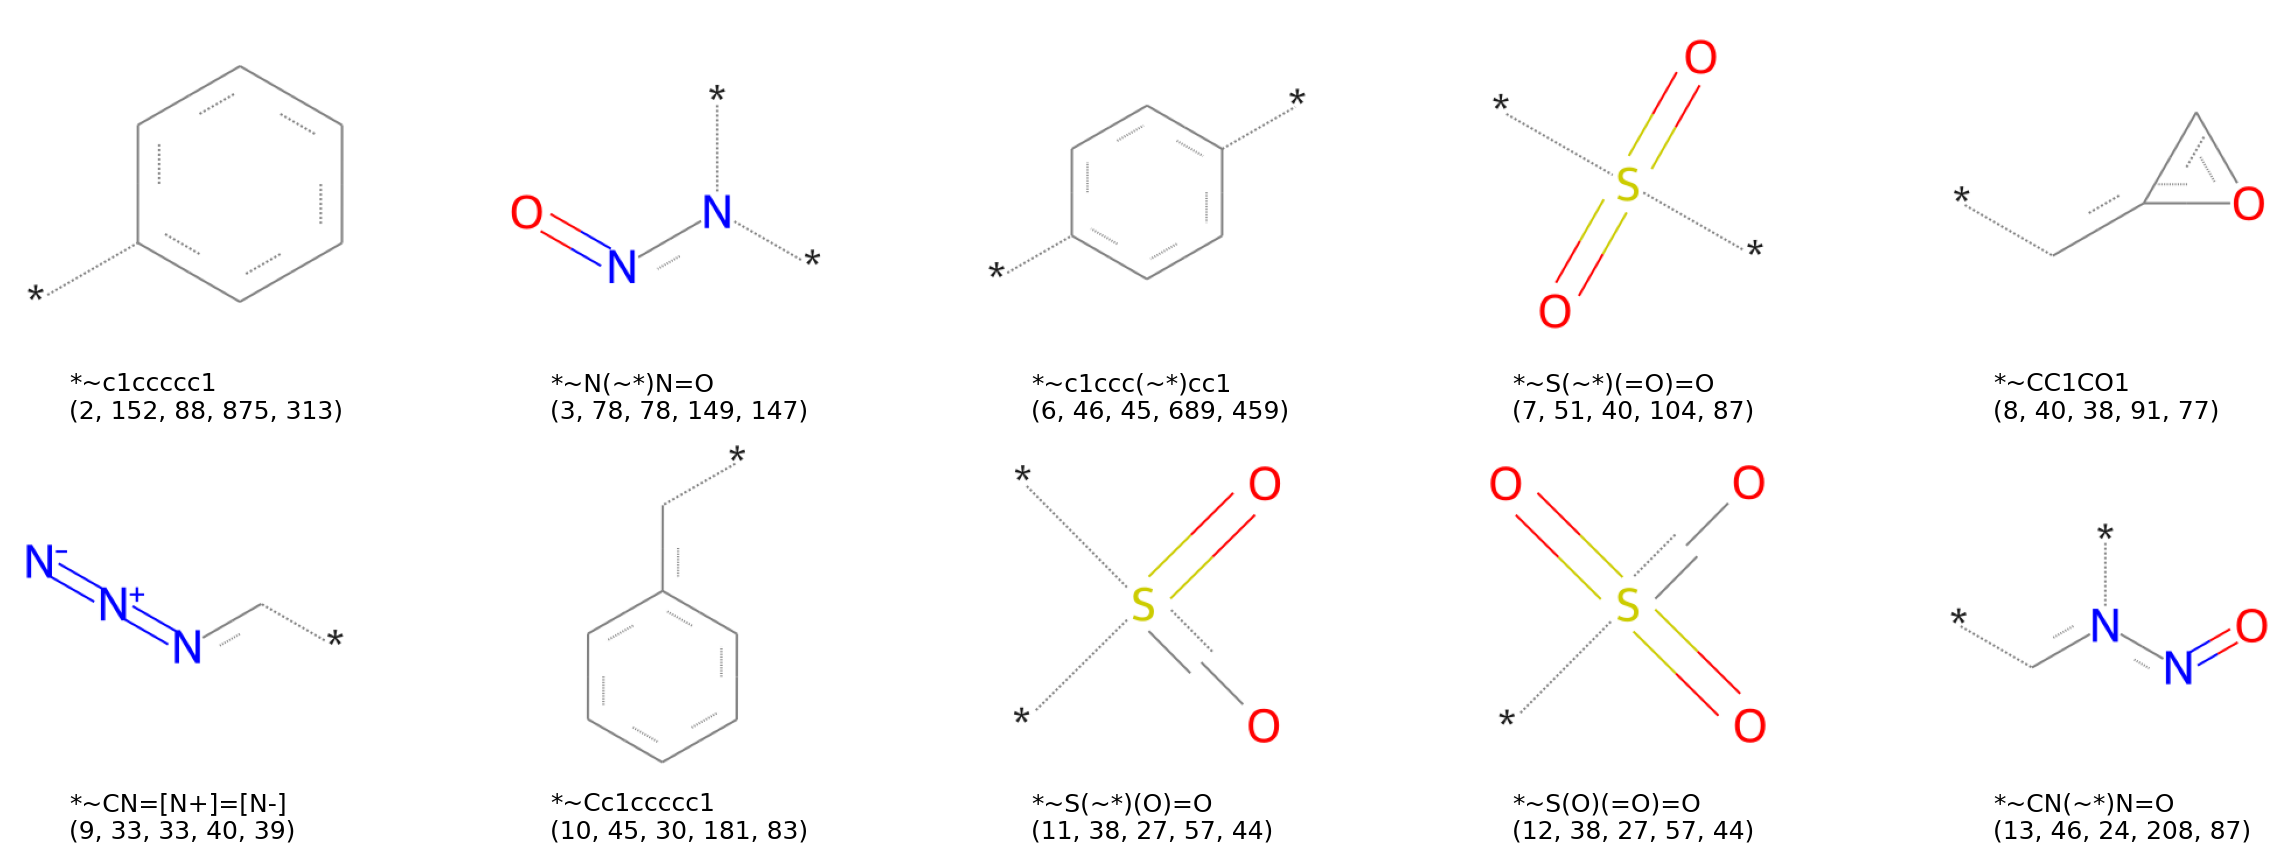

In [441]:
print('Three element fragments')
drawGridMolecule(sub_three[1], labels=[s1+'\n'+str(s2) for s1, s2 in zip(sub_three[0],sub_three[2])])

Unlimited element fragments


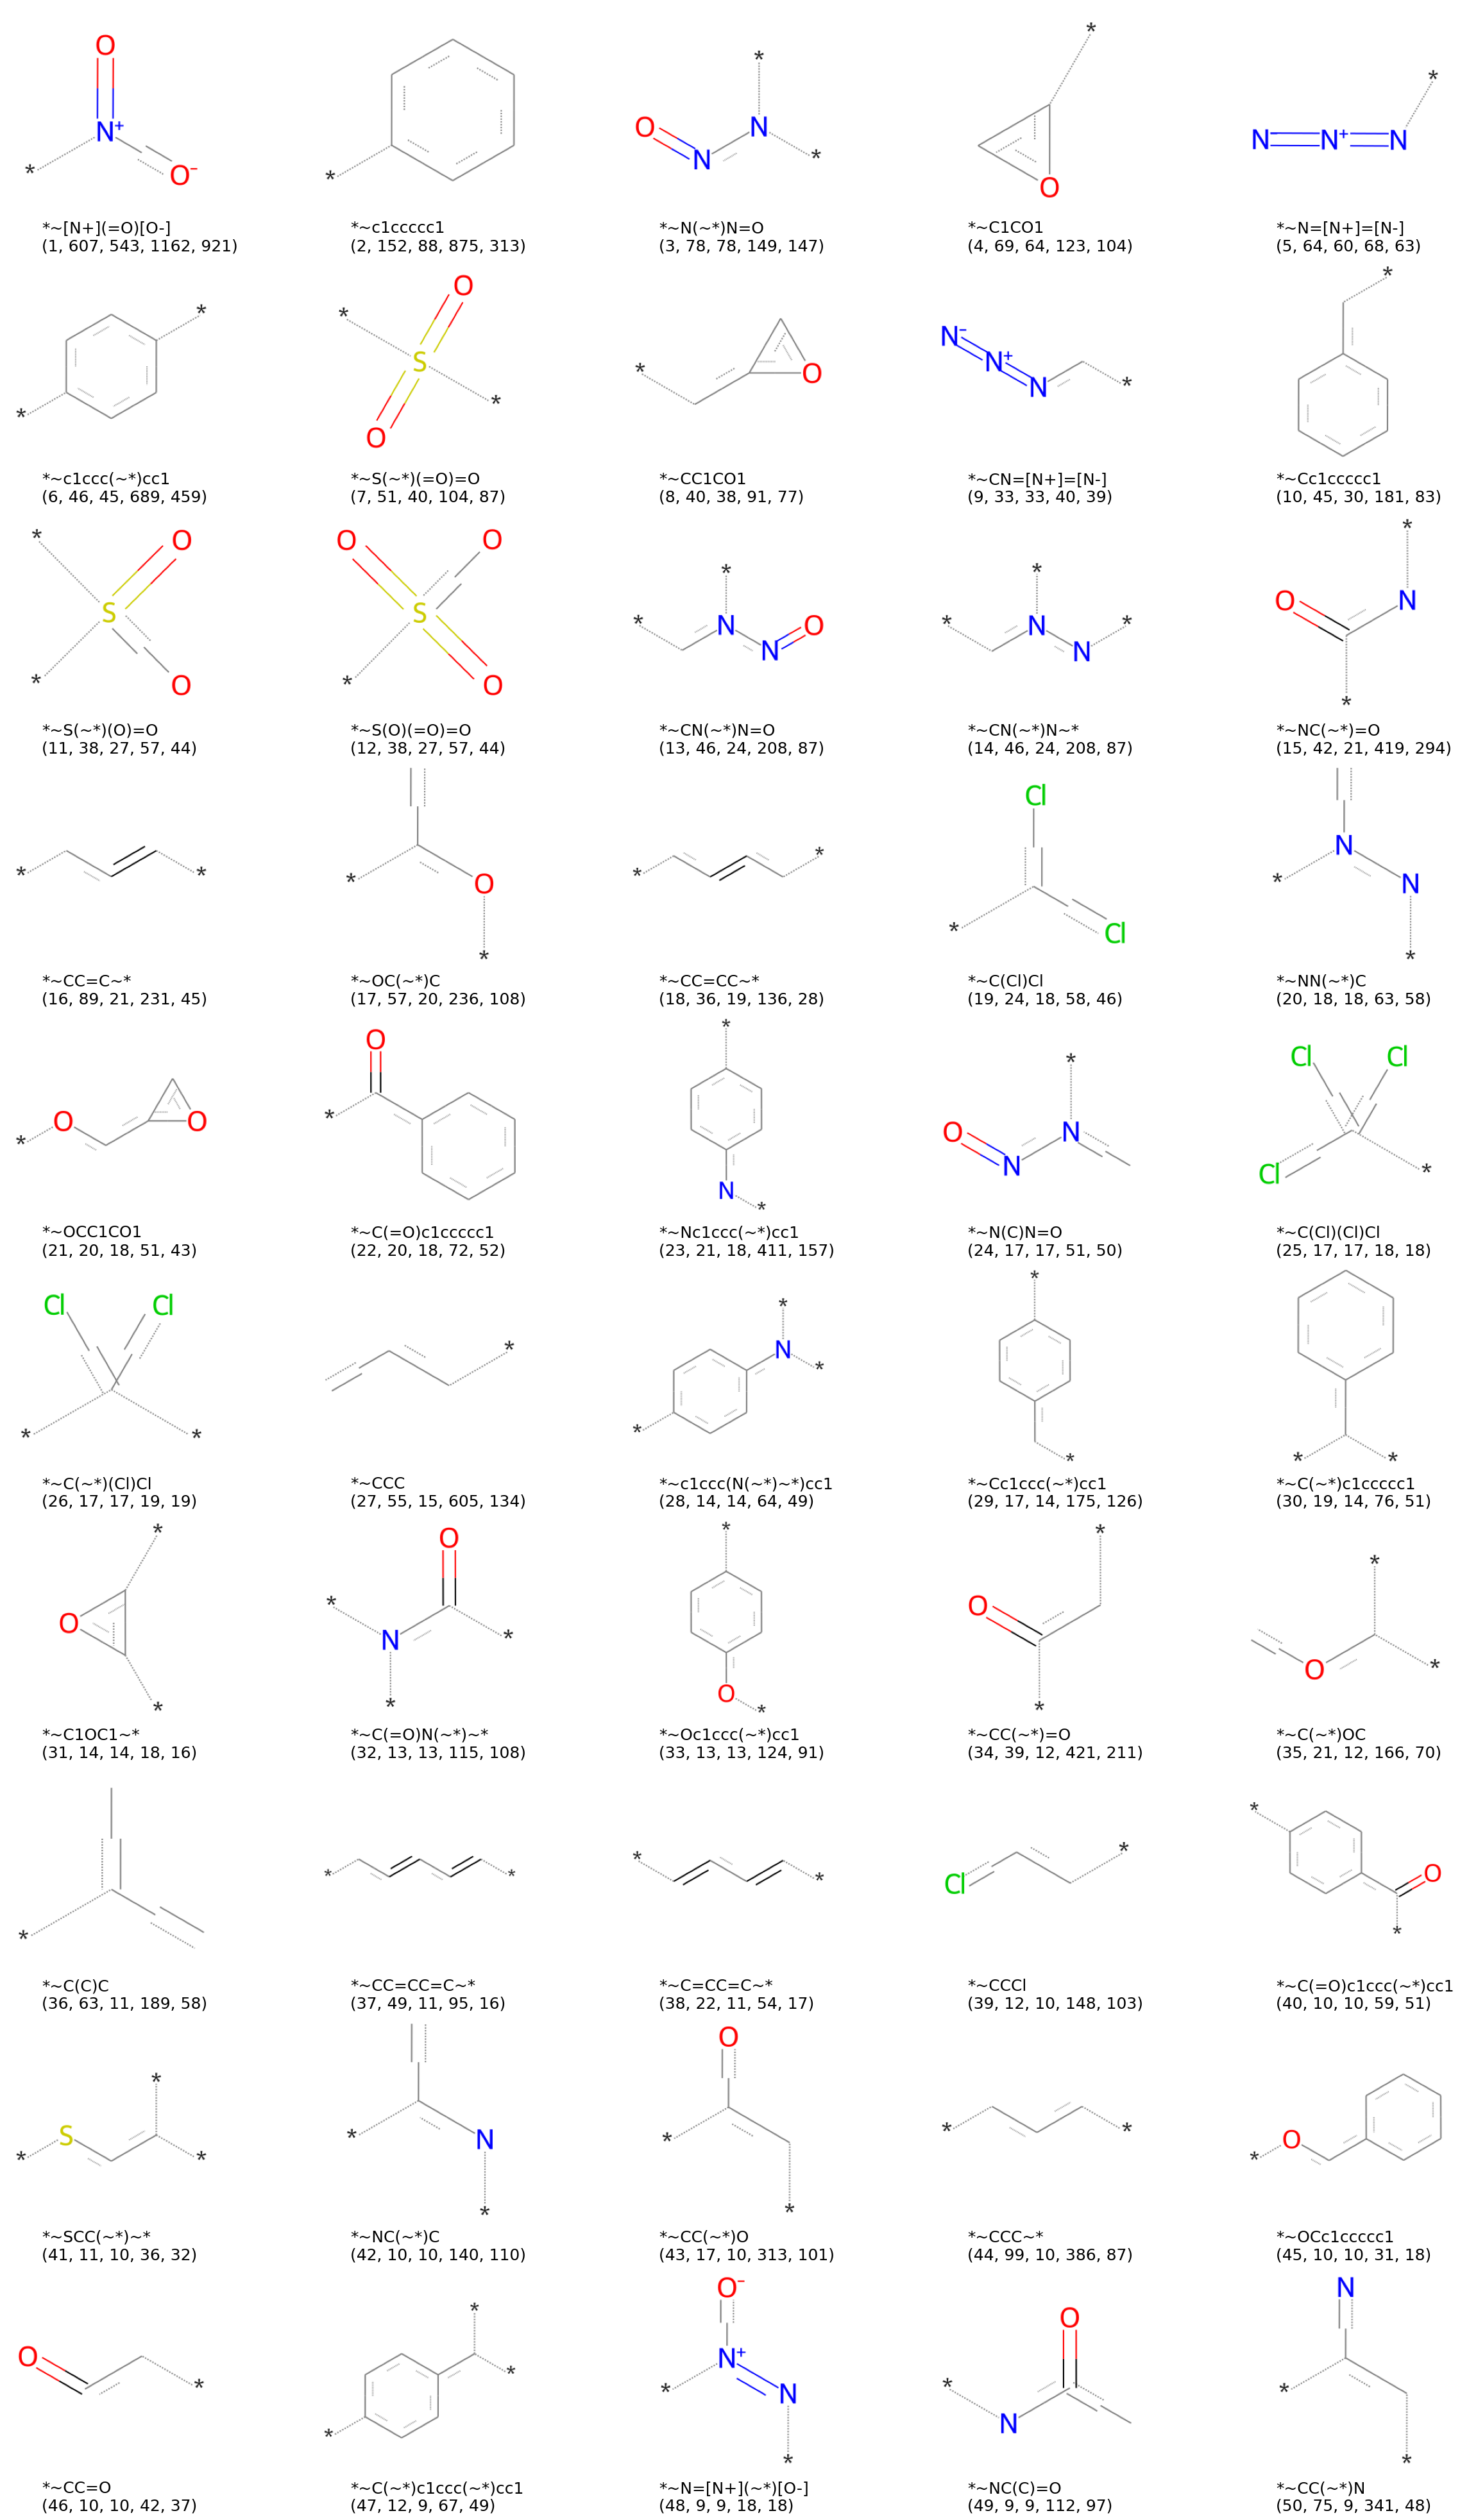

In [442]:
print('Unlimited element fragments')
drawGridMolecule(sub_all[1], labels=[s1+'\n'+str(s2) for s1, s2 in zip(sub_all[0],sub_all[2])])

# Number of fragments

In [443]:
if args.graphtask == 'classification':
    count_number_0 = 0
    count_number_0_all = 0
    for c in count_substructure[0]:
        count_number_0_all += 1
        if len(count_substructure[0][c])> 0:
            count_number_0 += 1
            # print(c, len(count_substructure[0][c]))
    count_number_1 = 0
    count_number_1_all = 0
    for c in count_substructure[1]:
        count_number_1_all += 1
        if len(count_substructure[1][c])> 0:
            count_number_1 += 1
            # print(c, len(count_substructure[1][c]))

    print('Predicted as 0:')
    print('- Number of smiles that have important fragments:', count_number_0_all)
    print('- Number of smiles that have important fragments > 1:', count_number_0)
    print('- Percentage:', count_number_0/count_number_0_all)
    print('Predicted as 1:')
    print('- Number of smiles that have important fragments:', count_number_1_all)
    print('- Number of smiles that have important fragments > 1:', count_number_1)
    print('- Percentage:', count_number_1/count_number_1_all)

Predicted as 0:
- Number of smiles that have important fragments: 2592
- Number of smiles that have important fragments > 1: 1092
- Percentage: 0.4212962962962963
Predicted as 1:
- Number of smiles that have important fragments: 3913
- Number of smiles that have important fragments > 1: 1292
- Percentage: 0.3301814464605162


In [444]:
predicted = 1
print("Number of all fragment from compounds predicted as "+str(predicted), len(num_substructure[predicted]))
print("Number of important fragment from compounds predicted as "+str(predicted), len(attention_substructure[predicted]))
print("Percentage of important per all fragments from compounds predicted as "+str(predicted), len(attention_substructure[predicted])/len(num_substructure[predicted]))

Number of all fragment from compounds predicted as 1 113270
Number of important fragment from compounds predicted as 1 3417
Percentage of important per all fragments from compounds predicted as 1 0.0301668579500309


# Calculate statistics

In [445]:
# calculate statistics
predicted = 1

sub_list = list()

num_sub_passed = list()
num_smiles_passed = list()

num_sub_all = list()
num_smiles_all = list()

for i, a in enumerate(att_1):
    sub_list.append(a)
    num_sub_passed.append(len(att_1[a]))
    num_smiles_passed.append( len(set(att_1[a])))
    num_sub_all.append(len(num_substructure[predicted][a]))
    num_smiles_all.append(len(set(num_substructure[predicted][a])))
    
sub_df = pd.DataFrame({'sub_list': sub_list,
                       'num_sub_passed': num_sub_passed,
                       'num_smiles_passed': num_smiles_passed,
                       'num_sub_all': num_sub_all,
                       'num_smiles_all': num_smiles_all})

display(sub_df)

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
0        *~[N+](=O)[O-]             607                543         1162   
1            *~c1ccccc1             152                 88          875   
2            *~N(~*)N=O              78                 78          149   
3               *~C1CO1              69                 64          123   
4         *~N=[N+]=[N-]              64                 60           68   
...                 ...             ...                ...          ...   
3412  *~CC(CCl)(CCl)CCl               1                  1            1   
3413  *~CC(C~*)(C~*)C~*               1                  1            4   
3414           *~C(N)CS               1                  1            1   
3415    *~c1ccc(O)cc1~*               1                  1            5   
3416         *~N1CCN=N1               1                  1            3   

      num_smiles_all  
0                921  
1                313  
2                147  
3                104  
4                 63  
...              ...  
3412               1  
3413               4  
3414               1  
3415               5  
3416               3  

[3417 rows x 5 columns]

In [446]:
# calculate percentage of smiles that have important fragments/ all smiles
sub_df['percent_smiles_passed'] = (sub_df['num_smiles_passed']/sub_df['num_smiles_all'])*100
sub_df

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
0        *~[N+](=O)[O-]             607                543         1162   
1            *~c1ccccc1             152                 88          875   
2            *~N(~*)N=O              78                 78          149   
3               *~C1CO1              69                 64          123   
4         *~N=[N+]=[N-]              64                 60           68   
...                 ...             ...                ...          ...   
3412  *~CC(CCl)(CCl)CCl               1                  1            1   
3413  *~CC(C~*)(C~*)C~*               1                  1            4   
3414           *~C(N)CS               1                  1            1   
3415    *~c1ccc(O)cc1~*               1                  1            5   
3416         *~N1CCN=N1               1                  1            3   

      num_smiles_all  percent_smiles_passed  
0                921              58.957655  
1                313              28.115016  
2                147              53.061224  
3                104              61.538462  
4                 63              95.238095  
...              ...                    ...  
3412               1             100.000000  
3413               4              25.000000  
3414               1             100.000000  
3415               5              20.000000  
3416               3              33.333333  

[3417 rows x 6 columns]

In [447]:
# merge statistics with scores and sort by scores
sub_df = sub_df.merge(df_score, how='inner', left_on='sub_list', right_on='fragment').sort_values(by=['score'], ascending=False)
sub_df

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
804        *~c1c[nH]cn1               2                  2            2   
3398      *~C=[N+]=[N-]               1                  1            1   
3172          *~C1NC1~*               1                  1            1   
304           *~N(O)N=O               3                  3            3   
1961            *~SCCBr               1                  1            1   
...                 ...             ...                ...          ...   
71             *~C(C)=O               7                  7          346   
2816         *~C(~*)OCC               1                  1           32   
457           *~CCCCC~*               2                  2           24   
1263           *~CCCC~*               1                  1           53   
3227  *~C(~*)(~*)C(O)=O               1                  1            3   

      num_smiles_all  percent_smiles_passed           fragment     score  
804                2             100.000000       *~c1c[nH]cn1  0.423927  
3398               1             100.000000      *~C=[N+]=[N-]  0.397933  
3172               1             100.000000          *~C1NC1~*  0.397742  
304                3             100.000000          *~N(O)N=O  0.387821  
1961               1             100.000000            *~SCCBr  0.384200  
...              ...                    ...                ...       ...  
71               267               2.621723           *~C(C)=O -0.136942  
2816              31               3.225806         *~C(~*)OCC -0.140986  
457                7              28.571429          *~CCCCC~* -0.146919  
1263              19               5.263158           *~CCCC~* -0.148455  
3227               3              33.333333  *~C(~*)(~*)C(O)=O -0.152264  

[3417 rows x 8 columns]

In [448]:
# query
sub_df[sub_df['sub_list'] == '*~[N+](=O)[O-]']

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
0  *~[N+](=O)[O-]             607                543         1162   

   num_smiles_all  percent_smiles_passed        fragment     score  
0             921              58.957655  *~[N+](=O)[O-]  0.235697

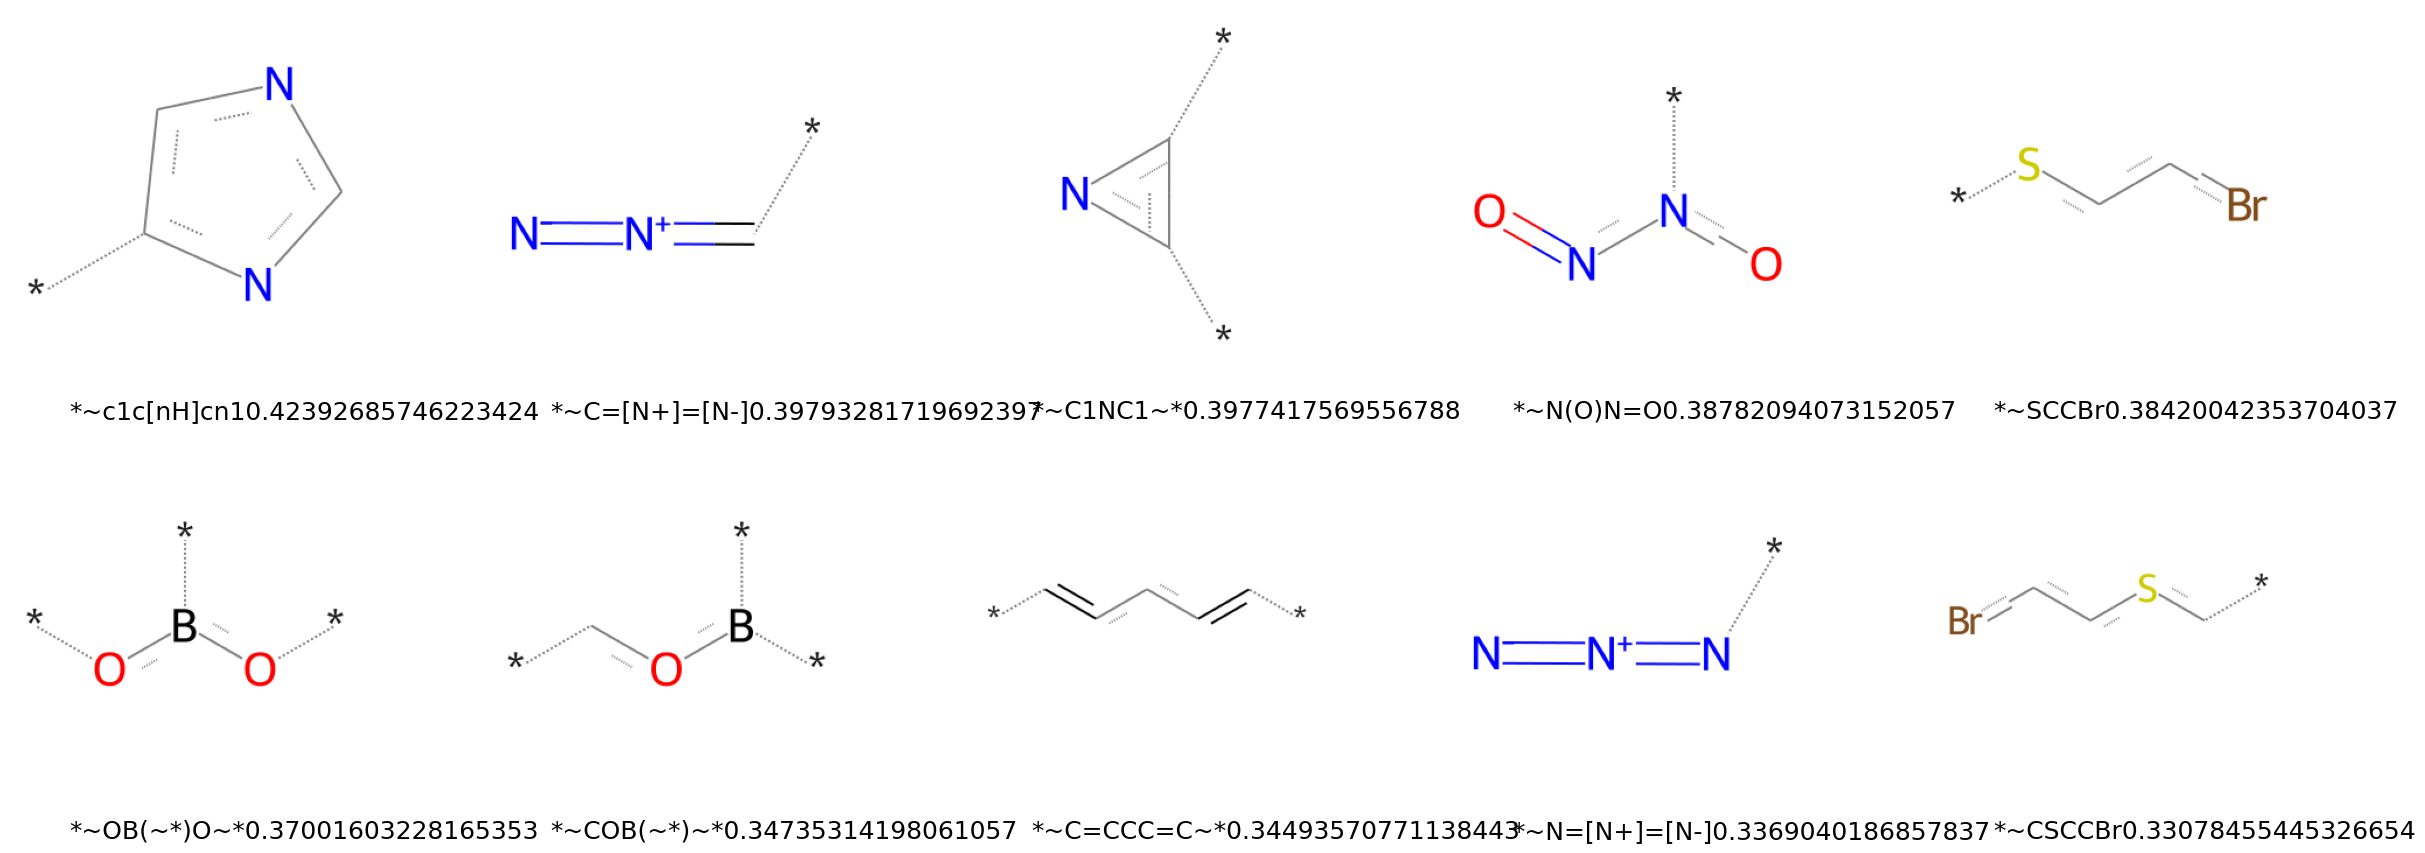

In [449]:
# top 10 highest scores
top = 10
labels = list()
for f, s in sub_df[['sub_list', 'score']].values[:top]:
    labels.append(f + str(s))
drawGridMolecule([Chem.MolFromSmarts(f) for f in sub_df['sub_list'][:top]], labels=labels)

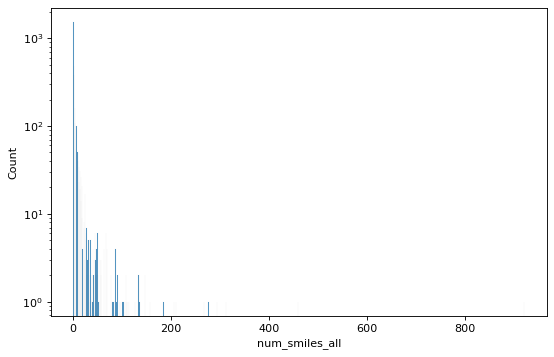

In [450]:
figure(figsize=(8, 5), dpi=80)
fig = sns.histplot(sub_df['num_smiles_all'])
fig.set_yscale("log")

## Percentile for selection

In [451]:
percentile = 90
if 't01' in args.file:
    percentile = 95
elif 't04' in args.file:
    percentile = 95
elif 't07' in args.file:
    percentile = 75
elif 'bbbp' in args.file:
    percentile = 75
print(percentile)

95


5.0


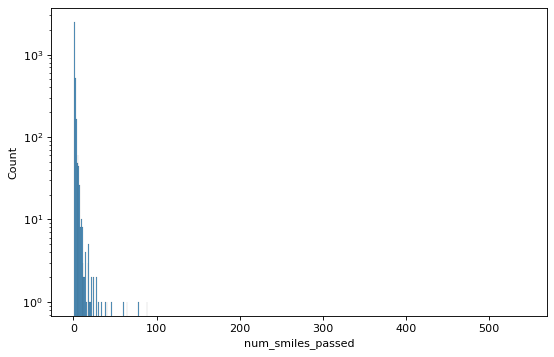

In [452]:
figure(figsize=(8, 5), dpi=80)
fig = sns.histplot(sub_df['num_smiles_passed'], bins=np.arange(0, max(sub_df['num_smiles_passed']), 1))
fig.set_yscale("log")
print(np.percentile(sub_df['num_smiles_passed'], percentile))

8.0


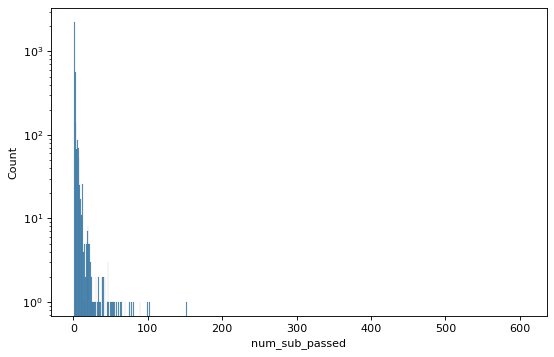

In [453]:
figure(figsize=(8, 5), dpi=80)
fig = sns.histplot(sub_df['num_sub_passed'], bins=np.arange(0, max(sub_df['num_sub_passed']), 1))
fig.set_yscale("log")
print(np.percentile(sub_df['num_sub_passed'], percentile))

In [454]:
sub_df.sort_values(by=['percent_smiles_passed','num_smiles_all'], ascending=False)

sub_list  num_sub_passed  num_smiles_passed  \
180                     *~CC=C(C)C~*              24                  5   
176        *~c1ccc(C(=O)ON(~*)~*)cc1               5                  5   
175   *~C(~*)N(~*)OC(=O)c1ccc(~*)cc1               5                  5   
177   *~C(=O)N(~*)OC(=O)c1ccc(~*)cc1               5                  5   
178      *~CON(~*)OC(=O)c1ccc(~*)cc1               5                  5   
...                              ...             ...                ...   
1682                   *~c1ccc(N)cc1               1                  1   
1066                       *~N(~*)CC               1                  1   
660                      *~CN(~*)C~*               2                  2   
3022                     *~CCN(~*)~*               1                  1   
1156                        *~C(O)=O               1                  1   

      num_sub_all  num_smiles_all  percent_smiles_passed  \
180            45               5             100.000000   
176             5               5             100.000000   
175             5               5             100.000000   
177             5               5             100.000000   
178             5               5             100.000000   
...           ...             ...                    ...   
1682          105              70               1.428571   
1066          168              70               1.428571   
660           242             147               1.360544   
3022          204             112               0.892857   
1156          208             185               0.540541   

                            fragment     score  
180                     *~CC=C(C)C~*  0.140903  
176        *~c1ccc(C(=O)ON(~*)~*)cc1  0.063161  
175   *~C(~*)N(~*)OC(=O)c1ccc(~*)cc1  0.051067  
177   *~C(=O)N(~*)OC(=O)c1ccc(~*)cc1  0.051067  
178      *~CON(~*)OC(=O)c1ccc(~*)cc1  0.050656  
...                              ...       ...  
1682                   *~c1ccc(N)cc1  0.037409  
1066                       *~N(~*)CC -0.065810  
660                      *~CN(~*)C~* -0.081130  
3022                     *~CCN(~*)~* -0.022169  
1156                        *~C(O)=O -0.099734  

[3417 rows x 8 columns]

In [455]:
# sort by percentage of smiles that have important fragments and number of smiles that have fragments
# filter only number of smiles that have important fragments > "percentile" percentile and percentage of smiles that have important fragments > 50
sub_df_sorted = sub_df.sort_values(by=['percent_smiles_passed','num_smiles_all'], ascending=False)
sub_df_sorted_50 = sub_df_sorted[(sub_df_sorted['num_smiles_passed'] >= np.percentile(sub_df['num_smiles_passed'], percentile)) & (sub_df_sorted['percent_smiles_passed'] >= 50)] 
sub_df_sorted_50

sub_list  num_sub_passed  num_smiles_passed  \
180                    *~CC=C(C)C~*              24                  5   
176       *~c1ccc(C(=O)ON(~*)~*)cc1               5                  5   
175  *~C(~*)N(~*)OC(=O)c1ccc(~*)cc1               5                  5   
177  *~C(=O)N(~*)OC(=O)c1ccc(~*)cc1               5                  5   
178     *~CON(~*)OC(=O)c1ccc(~*)cc1               5                  5   
..                              ...             ...                ...   
65         *~C(~*)N(~*)c1ccc(~*)cc1               7                  7   
85             *~OC(=O)c1ccc(~*)cc1               7                  7   
130                       *~C(Br)Br               6                  6   
140          *~c1ccc(N(O)C(C)=O)cc1               5                  5   
141          *~C(C)N(O)c1ccc(~*)cc1               5                  5   

     num_sub_all  num_smiles_all  percent_smiles_passed  \
180           45               5                  100.0   
176            5               5                  100.0   
175            5               5                  100.0   
177            5               5                  100.0   
178            5               5                  100.0   
..           ...             ...                    ...   
65            14              14                   50.0   
85            15              14                   50.0   
130           13              12                   50.0   
140           10              10                   50.0   
141           10              10                   50.0   

                           fragment     score  
180                    *~CC=C(C)C~*  0.140903  
176       *~c1ccc(C(=O)ON(~*)~*)cc1  0.063161  
175  *~C(~*)N(~*)OC(=O)c1ccc(~*)cc1  0.051067  
177  *~C(=O)N(~*)OC(=O)c1ccc(~*)cc1  0.051067  
178     *~CON(~*)OC(=O)c1ccc(~*)cc1  0.050656  
..                              ...       ...  
65         *~C(~*)N(~*)c1ccc(~*)cc1  0.034355  
85             *~OC(=O)c1ccc(~*)cc1  0.012244  
130                       *~C(Br)Br  0.068429  
140          *~c1ccc(N(O)C(C)=O)cc1  0.021470  
141          *~C(C)N(O)c1ccc(~*)cc1  0.021470  

[83 rows x 8 columns]

In [456]:
# sort by score and percentage of smiles that have important fragments
# filter only percentage of smiles that have important fragments > 50 and score > 0
sub_df_sorted = sub_df.sort_values(by=['score', 'percent_smiles_passed'], ascending=False)
sub_df_sorted_50 = sub_df_sorted[(sub_df_sorted['percent_smiles_passed'] >= 50) & (sub_df_sorted['score'] > 0)] 
sub_df_sorted_50

sub_list  num_sub_passed  num_smiles_passed  \
804                  *~c1c[nH]cn1               2                  2   
3398                *~C=[N+]=[N-]               1                  1   
3172                    *~C1NC1~*               1                  1   
304                     *~N(O)N=O               3                  3   
1961                      *~SCCBr               1                  1   
...                           ...             ...                ...   
2272  *~CC(~*)C(~*)NC(C~*)C(~*)=O               7                  1   
2340   *~CC(N)C(~*)NC(C~*)C(~*)=O               7                  1   
2284  *~CC(~*)C(=O)NC(C~*)C(~*)=O               7                  1   
2413       *~CC(~*)NC(~*)C(~*)C~*              20                  1   
1823              *~C(Cl)c1ccccc1               1                  1   

      num_sub_all  num_smiles_all  percent_smiles_passed  \
804             2               2                  100.0   
3398            1               1                  100.0   
3172            1               1                  100.0   
304             3               3                  100.0   
1961            1               1                  100.0   
...           ...             ...                    ...   
2272           18               1                  100.0   
2340           18               1                  100.0   
2284           18               1                  100.0   
2413           54               1                  100.0   
1823            2               2                   50.0   

                         fragment     score  
804                  *~c1c[nH]cn1  0.423927  
3398                *~C=[N+]=[N-]  0.397933  
3172                    *~C1NC1~*  0.397742  
304                     *~N(O)N=O  0.387821  
1961                      *~SCCBr  0.384200  
...                           ...       ...  
2272  *~CC(~*)C(~*)NC(C~*)C(~*)=O  0.001921  
2340   *~CC(N)C(~*)NC(C~*)C(~*)=O  0.001921  
2284  *~CC(~*)C(=O)NC(C~*)C(~*)=O  0.001921  
2413       *~CC(~*)NC(~*)C(~*)C~*  0.001362  
1823              *~C(Cl)c1ccccc1  0.000737  

[1863 rows x 8 columns]

# Final condition!! -> Potential Substructures

In [457]:
# sort by percentage of smiles that have important fragments and number of smiles that have fragments
# filter only number of smiles that have important fragments > "percentile" percentile and percentage of smiles that have important fragments > 50 and score > 0
sub_df_sorted = sub_df.sort_values(by=['percent_smiles_passed','num_smiles_all'], ascending=False)
sub_df_sorted_50 = sub_df_sorted[(sub_df_sorted['num_smiles_passed'] >= np.percentile(sub_df['num_smiles_passed'], percentile)) & (sub_df_sorted['percent_smiles_passed'] >= 50) & (sub_df_sorted['score'] > 0)] 
display(len(sub_df_sorted_50), sub_df_sorted_50)

83

sub_list  num_sub_passed  num_smiles_passed  \
180                    *~CC=C(C)C~*              24                  5   
176       *~c1ccc(C(=O)ON(~*)~*)cc1               5                  5   
175  *~C(~*)N(~*)OC(=O)c1ccc(~*)cc1               5                  5   
177  *~C(=O)N(~*)OC(=O)c1ccc(~*)cc1               5                  5   
178     *~CON(~*)OC(=O)c1ccc(~*)cc1               5                  5   
..                              ...             ...                ...   
65         *~C(~*)N(~*)c1ccc(~*)cc1               7                  7   
85             *~OC(=O)c1ccc(~*)cc1               7                  7   
130                       *~C(Br)Br               6                  6   
140          *~c1ccc(N(O)C(C)=O)cc1               5                  5   
141          *~C(C)N(O)c1ccc(~*)cc1               5                  5   

     num_sub_all  num_smiles_all  percent_smiles_passed  \
180           45               5                  100.0   
176            5               5                  100.0   
175            5               5                  100.0   
177            5               5                  100.0   
178            5               5                  100.0   
..           ...             ...                    ...   
65            14              14                   50.0   
85            15              14                   50.0   
130           13              12                   50.0   
140           10              10                   50.0   
141           10              10                   50.0   

                           fragment     score  
180                    *~CC=C(C)C~*  0.140903  
176       *~c1ccc(C(=O)ON(~*)~*)cc1  0.063161  
175  *~C(~*)N(~*)OC(=O)c1ccc(~*)cc1  0.051067  
177  *~C(=O)N(~*)OC(=O)c1ccc(~*)cc1  0.051067  
178     *~CON(~*)OC(=O)c1ccc(~*)cc1  0.050656  
..                              ...       ...  
65         *~C(~*)N(~*)c1ccc(~*)cc1  0.034355  
85             *~OC(=O)c1ccc(~*)cc1  0.012244  
130                       *~C(Br)Br  0.068429  
140          *~c1ccc(N(O)C(C)=O)cc1  0.021470  
141          *~C(C)N(O)c1ccc(~*)cc1  0.021470  

[83 rows x 8 columns]

# Save results

In [458]:
path_fold = 'dataset/'+file
if len(args.reduced) > 0:
    sub_df_sorted_50.to_csv(path_fold+'/potentsub_'+args.reduced[0]+"_"+args.schema+".csv")
else:
    sub_df_sorted_50.to_csv(path_fold+'/potentsub_'+args.schema+".csv")

# Detect redundancy and get only largest potential substructures

In [459]:
Fragments = list(sub_df_sorted_50['sub_list'])
Fragments_del_list = []
for i in tqdm(range(len(Fragments)-1)):
    for j in range(i+1,len(Fragments)):
        try:
            patt1 = Chem.MolFromSmarts(Fragments[i])
            patt2 = Chem.MolFromSmarts(Fragments[j])
            smiles1 = Chem.MolFromSmiles(Fragments[i])
            smiles2 = Chem.MolFromSmiles(Fragments[j])
            frag1 = smiles2.HasSubstructMatch(patt1)
            frag2 = smiles1.HasSubstructMatch(patt2)
            if frag1 == True:
                if frag2 == False:
                    Fragments_del_list.append(Fragments[i])
            if frag2 == True:
                if frag1 == False:
                    Fragments_del_list.append(Fragments[j])
            if frag1 == False:
                if frag2 == False:
                    pass
        except:
            pass
Final_Fragments_list = [f for f in Fragments if f not in Fragments_del_list]
print(len(Final_Fragments_list), Final_Fragments_list)

100%|██████████| 82/82 [00:01<00:00, 63.13it/s]

20 ['*~CC=C(C)C~*', '*~C(=O)N(~*)OC(=O)c1ccc(~*)cc1', '*~CON(~*)OC(=O)c1ccc(~*)cc1', '*~C(=O)N(OCc1ccc(~*)cc1)OC(C)=O', '*~ON=O', '*~SCCCl', '*~CON(O~*)C(=O)c1ccc(~*)cc1', '*~c1ccc(C(=O)N(~*)OC(C)=O)cc1', '*~CN=[N+]=[N-]', '*~C1OC1C(~*)=O', '*~C(~*)C(Cl)(Cl)Cl', '*~C(Cl)=CCl', '*~S(O)(=O)=O', '*~[N+](=O)[O-]', '*~c1cccnc1', '*~CC=CC=CC=C~*', '*~N(~*)N=O', '*~N=[N+](~*)[O-]', '*~C(Br)Br', '*~c1ccc(N(O)C(C)=O)cc1']


# Save result again (unique)

In [460]:
sub_df_sorted_50_unique = sub_df_sorted_50[sub_df_sorted_50['sub_list'].isin(Final_Fragments_list)]
if len(args.reduced) > 0:
    sub_df_sorted_50_unique.to_csv(path_fold+'/potentsub_'+args.reduced[0]+"_"+args.schema+"_unique.csv")
else:
    sub_df_sorted_50_unique.to_csv(path_fold+'/potentsub_'+args.schema+"_unique.csv")

print(len(sub_df_sorted_50_unique))
display(sub_df_sorted_50_unique)

20


sub_list  num_sub_passed  num_smiles_passed  \
180                     *~CC=C(C)C~*              24                  5   
177   *~C(=O)N(~*)OC(=O)c1ccc(~*)cc1               5                  5   
178      *~CON(~*)OC(=O)c1ccc(~*)cc1               5                  5   
76   *~C(=O)N(OCc1ccc(~*)cc1)OC(C)=O               7                  7   
126                           *~ON=O               6                  6   
134                          *~SCCCl               7                  6   
99       *~CON(O~*)C(=O)c1ccc(~*)cc1              18                  6   
94     *~c1ccc(C(=O)N(~*)OC(C)=O)cc1               6                  6   
8                     *~CN=[N+]=[N-]              33                 33   
60                    *~C1OC1C(~*)=O               8                  8   
72                *~C(~*)C(Cl)(Cl)Cl               7                  7   
121                      *~C(Cl)=CCl               6                  6   
11                      *~S(O)(=O)=O              38                 27   
0                     *~[N+](=O)[O-]             607                543   
132                       *~c1cccnc1               6                  6   
84                    *~CC=CC=CC=C~*              25                  7   
2                         *~N(~*)N=O              78                 78   
47                  *~N=[N+](~*)[O-]               9                  9   
130                        *~C(Br)Br               6                  6   
140           *~c1ccc(N(O)C(C)=O)cc1               5                  5   

     num_sub_all  num_smiles_all  percent_smiles_passed  \
180           45               5             100.000000   
177            5               5             100.000000   
178            5               5             100.000000   
76             8               8              87.500000   
126            7               7              85.714286   
134            8               7              85.714286   
99            21               7              85.714286   
94             7               7              85.714286   
8             40              39              84.615385   
60            10              10              80.000000   
72             9               9              77.777778   
121            9               9              66.666667   
11            57              44              61.363636   
0           1162             921              58.957655   
132           11              11              54.545455   
84            64              13              53.846154   
2            149             147              53.061224   
47            18              18              50.000000   
130           13              12              50.000000   
140           10              10              50.000000   

                            fragment     score  
180                     *~CC=C(C)C~*  0.140903  
177   *~C(=O)N(~*)OC(=O)c1ccc(~*)cc1  0.051067  
178      *~CON(~*)OC(=O)c1ccc(~*)cc1  0.050656  
76   *~C(=O)N(OCc1ccc(~*)cc1)OC(C)=O  0.024113  
126                           *~ON=O  0.271916  
134                          *~SCCCl  0.215023  
99       *~CON(O~*)C(=O)c1ccc(~*)cc1  0.105900  
94     *~c1ccc(C(=O)N(~*)OC(C)=O)cc1  0.103354  
8                     *~CN=[N+]=[N-]  0.235226  
60                    *~C1OC1C(~*)=O  0.175374  
72                *~C(~*)C(Cl)(Cl)Cl  0.070519  
121                      *~C(Cl)=CCl  0.182796  
11                      *~S(O)(=O)=O  0.231005  
0                     *~[N+](=O)[O-]  0.235697  
132                       *~c1cccnc1  0.191899  
84                    *~CC=CC=CC=C~*  0.140109  
2                         *~N(~*)N=O  0.148281  
47                  *~N=[N+](~*)[O-]  0.173992  
130                        *~C(Br)Br  0.068429  
140           *~c1ccc(N(O)C(C)=O)cc1  0.021470

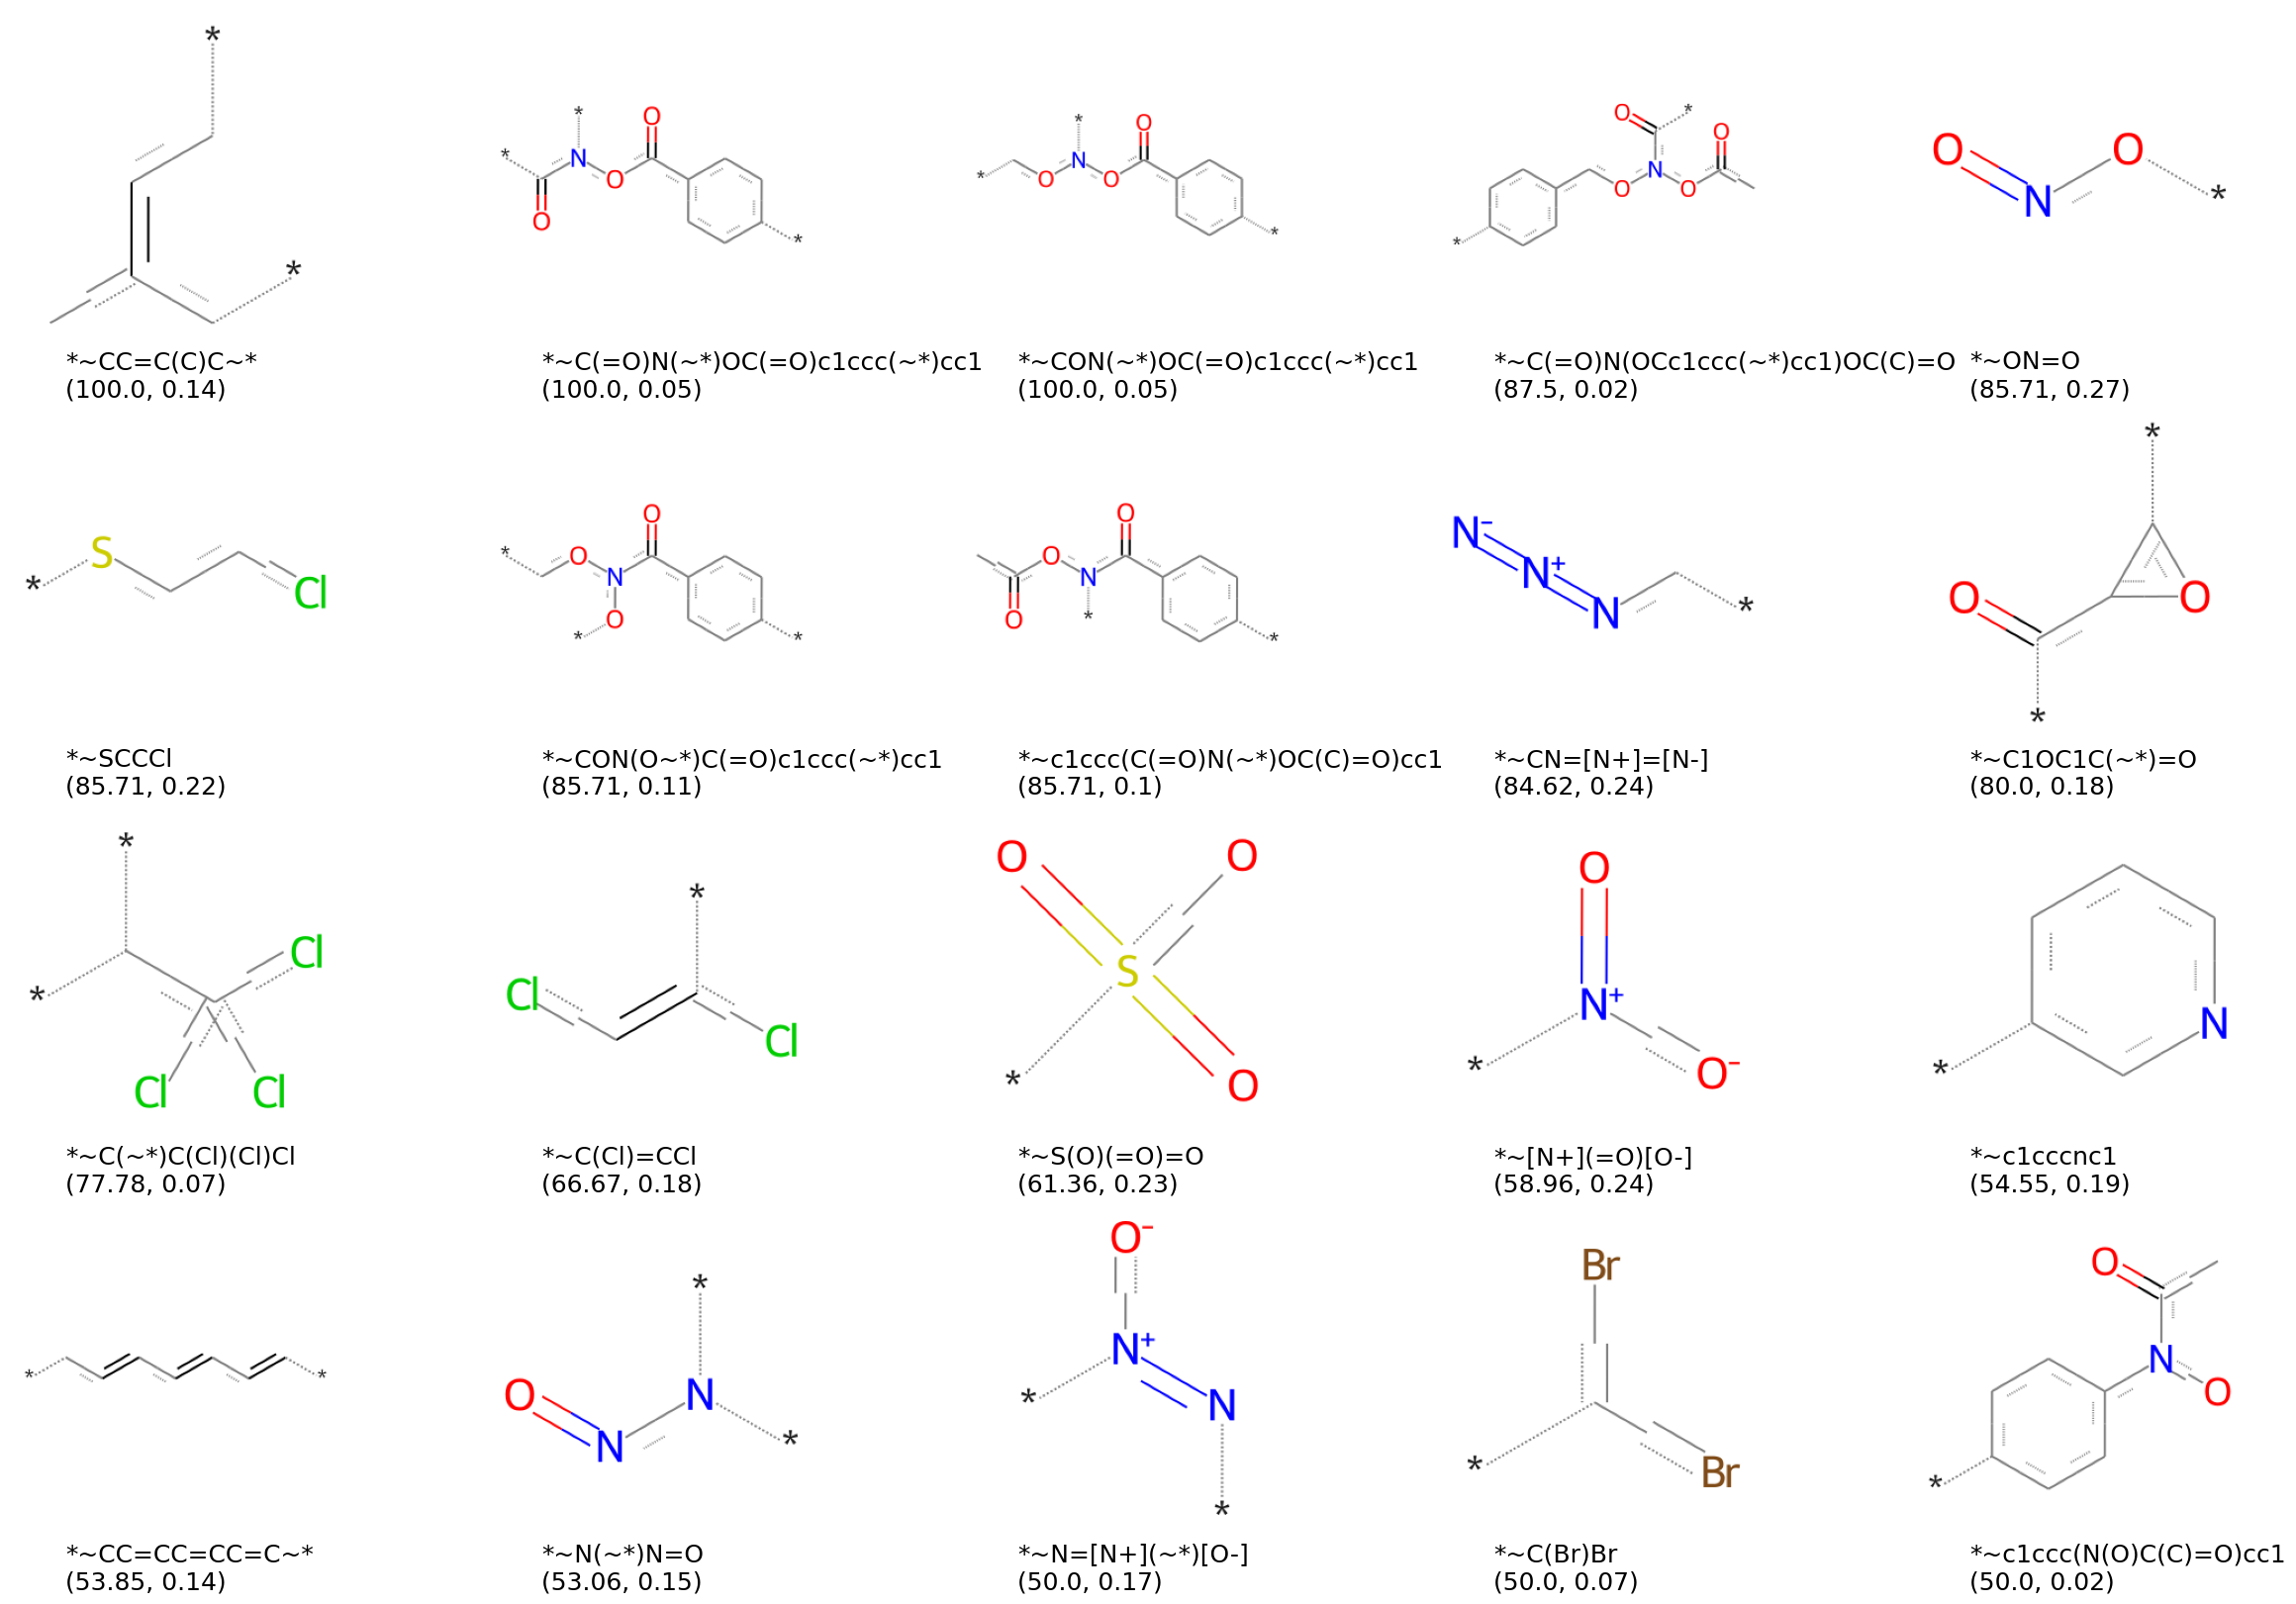

In [461]:
# drawGridMolecule([Chem.MolFromSmarts(f) for f in sub_df_sorted_50['sub_list']], labels=list(zip(sub_df_sorted_50['sub_list'],sub_df_sorted_50['score'])))
label_list = [s1+'\n'+str(s2) for s1, s2 in zip(sub_df_sorted_50_unique['sub_list'], zip(sub_df_sorted_50_unique['percent_smiles_passed'].round(decimals=2), sub_df_sorted_50_unique['score'].round(decimals=2)))]
drawGridMolecule([Chem.MolFromSmarts(f) for f in sub_df_sorted_50_unique['sub_list']], labels=label_list)
# drawGridMolecule([Chem.MolFromSmarts(f) for f in Final_Fragments_list], labels=list(Final_Fragments_list))


# Reported Structural Patterns

In [462]:
t01 = [
"[a!r0][$([NX3+](=[OX1])([O-])),$([NX3](=O)=O)]",
"[a!r0][NX3H2]",
"[NX3H1,SX2,OX2]1[CX4][CX4]1",
"[NX2]=[OX1]",
"[$([NX3H2]-[#7]),$([NX3H2]-[#8]),$([OX2H1]-[#7]),$([OX2H1]-[#8])]",
"[NX2]=[NX2]",
"[CX4][Cl,Br,I]",
"[$([aR3]),$([$([aR2]([aR])([aR])([aR]))].[$([aR2]([aR])([aR])([aR]))].[$([aR2]([aR])([aR])([aR]))].[$([aR2]([aR])([aR])([aR]))])]",
"[a!r0][$([NX3+](=[OX1])[O-]),$([NX3](=[OX1])=[OX1]);!$([NX3]aa-[$(C(F)(F)F),$(S(=O)(=O)[OH]),$(S(=O)(=O)[NX3]([#1,#6])[#1,#6]),$(S(=O)(=O)[a!r0]),$([CX4]([CH3])([CH3])[CH3])]);!$([NX3]aaa-[$(C(F)(F)F),$(S(=O)(=O)[OH]),$(S(=O)(=O)[NX3]([#1,#6])[#1,#6]),$(S(=O)(=O)[a!r0])]);!$([NX3]aaaa-[$(C(F)(F)F),$(S(=O)(=O)[OH]),$(S(=O)(=O)[NX3]([#1,#6])[#1,#6]),$(S(=O)(=O)[a!r0])])]",
"[a!r0][$([NH2]);!$([NH2]aa[$(C(F)(F)F),$(S(=O)(=O)[NX3]([#6,#1])[#6,#1]),$(S(=O)(=O)[OH]),$(S(=O)(=O)[a!r0]),$(C(=[OX1])[OH1]),$(C(=[OX1])[OX2][#6])]);!$([NH2]aaa[$(C(F)(F)F),$(S(=O)(=O)[NX3]([#6,#1])[#6,#1]),$(S(=O)(=O)[OH]),$(S(=O)(=O)[a!r0]),$(C(=[OX1])[OH]),$(C(=[OX1])[OX2][#6])]);!$([NH2]aaaa[$(C(F)(F)F),$(S(=O)(=O)[NX3]([#6,#1])[#6,#1]),$(S(=O)(=O)[OH]),$(S(=O)(=O)[a!r0]),$(C(=[OX1])[OH]),$(C(=[OX1])[OX2][#6])])]",
"[a!r0][NX2]=[OX1]",
"[OX1]=[NX2][OX2][CX4]",
"[OX1]=[NX2][NX3]([#6,#1])[#6,#1]",
"[CX4]1[OX2][CX4]1",
"[CX4]1[NX3H1][CX4]1",
"[$([NX2]=[NX2+]=[NX1-]),$(N=[NX2+]=N),$([NX2-]-[NX2+]#[NX1])]",
"[$([#6]=[NX2+]=N),$([#6]=[NX2]=[NX1]),$([#6]=[NX2+]=[NX1-]),$([#6]-[NX2+]#[NX1]),$([#6-]-[NX2+]#[NX1])]",
"[NX3!R][NX2!R]=[NX2!R]",
"[$([NX2]([a!r0])=[NX2][a!r0]);!$([NX2](aaS(=O)(=O)[OH])=[NX2]aaS(=O)(=O)[OH]);!$([NX2](aaS(=O)(=O)[OH])=[NX2]aaaS(=O)(=O)[OH]);!$([NX2](aaaS(=O)(=O)[OH])=[NX2]aaS(=O)(=O)[OH]);!$([NX2](aaS(=O)(=O)[OH])=[NX2]aaaaS(=O)(=O)[OH])!$([NX2](aaaaS(=O)(=O)[OH])=[NX2]aaS(=O)(=O)[OH]);!$([NX2](aaaS(=O)(=O)[OH])=[NX2]aaaS(=O)(=O)[OH]);!$([NX2](aaaS(=O)(=O)[OH])=[NX2]aaaaS(=O)(=O)[OH]);!$([NX2](aaaaS(=O)(=O)[OH])=[NX2]aaaS(=O)(=O)[OH]);!$([NX2](aaaaS(=O)(=O)[OH])=[NX2]aaaaS(=O)(=O)[OH])]",
"[$([NX3H2][#7]),$([NX3H2][#8]),$([OX2H1][#7]),$([OX2H1][#8]);!$([NH2][#7][$([OX2]-[OX2][#6]),$([NX3]([!#1])[NX3]([!#1]))]);!$([NH2][#8][$([OX2]-[OX2][#6]),$([NX3]([!#1])[NX3]([!#1]))]);!$([OH1][#7][$([OX2]-[OX2][#6]),$([NX3]([!#1])[NX3]([!#1]))]);!$([OH1][#8][$([OX2]-[OX2][#6]),$([NX3]([!#1])[NX3]([!#1]))]);!$([OH1][NX3H1][a!r0])]",
"[a!r0][NX3H1][OH1]",
"[Cl,Br,I][$([CX4]);!$([CX3](=[OX1,SX1,NX2]));!$([CH2][CH2][SX2,NX3])]",
"[Cl,Br,I][CX3](=[OX1])[#1,*&!$([OH1])&!$([SH1])]",
"[Cl,Br,I][CH2][CH2][SX2,NX3]",
"[$([$([aR3]),$([$([aR2]([aR])([aR])([aR]))].[$([aR2]([aR])([aR])([aR]))].[$([aR2]([aR])([aR])([aR]))].[$([aR2]([aR])([aR])([aR]))])]);!$([cR1H1]1[cR1H1][cR1][cR1][cR2]2[cR2]1[cR2]3[cR2]([cR1][cR1]2)[cR1][cR1][cR1H1][cR1H1]3);!$([cR1]1[cR1][cR1][cR1H1][cR2]2[cR2]1[cR2]3c([cR1H1][cR1H1]2)[cR1H1][cR1][cR1][cR1]3)]",
"[cR1H1]1[cR1H1][cR1][cR1][cR2]2[cR2]1[cR2]3[cR2]([cR1][cR1]2)[cR1][cR1][cR1H1][cR1H1]3",
"[cR1]1[cR1][cR1][cR1H1][cR2]2[cR2]1[cR2]3c([cR1H1][cR1H1]2)[cR1H1][cR1][cR1][cR1]3",
"[CX4][Sv6X4](=[OX1])(=[OX1])[OX2]",
"[CX3]=[CX3][CX3;H1]=[OX1]",
"[NX3][$([NX3](=[OX1])=[OX1]),$([NX3+](=[OX1][O-]))]",
"[$([a!r0][NX2+]#[NX1]),$([a!r0][NX2]#[NX1])]",
"[OX2]1[CX4][CX4][CX3]1(=[OX1])",
"[CX4][OX2][CX3H1]=[CX3H1]",
"[a!r0][NX3H1]-[NX3H1][CX4]",
"[a!r0][NX3;H1][CH3]",
"[a!r0][NH][OX2][CX3](=[OX1])",
"[*R1]1[*R2]2=[*R1][*R1]=[*R1][*R1]=[*R2]2[*R1][*R2]3=[*R1][*R1]=[*R1][*R1]=[*R2]13",
"[NX1]",
"[N](O)(O)"
]

t04 = ['c1ccc2[nH]cnc2c1',
'C1=CN(N=C1)C1=CC=CC=C1',
'n1cccc2ccccc12',
'C1=CC=C2C(=C1)C=CC(=N2)Cl',
'C1=CC=C(C=C1)S(=O)(=O)N',
'c1ccc(cc1)C(=O)N',
'C1=CC=C(C=C1)NC=O',
'*C(=O)O',
'C1C(=O)NC(=O)S1',
'*O*',
'*S(=O)(=O)N(*)(*)',
'*N(*)C(=O)*',
'F']

t07 = ['c1ccncc1',
'c2ccc1[nH]ncc1c2',
'C1(C=NC=C2)=C2C=CC=C1',
'O=C2c1ccccc1C(=O)N2',
'c1cn[nH]c1',
'C1(=NON=C1N)*',
'C1=CN=C(N=C1)N',
'C1=CC2=C(NC=C2)N=C1']

# ref https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0053-y
t11 = ['C12CCCCC1C3C(CCC3)CC2',
'NN',
'a[C!R]C(=O)[OH]',
'[#6]S(=O)(=O)N[#6]',
'c1ccccc1[NH2]',
'O=[S;X3]',
'[S;X2&!R]',
'a[C!R](=O)a',
'C[F,Cl,Br,I]',
'C1CC1N',
'[O]c1ccc([N])cc1',
'N1c2ccccc2Sc2ccccc12']

if 't01' in args.file:
    reportedtest = t01
elif 't04' in args.file:
    reportedtest = t04
elif 't07' in args.file:
    reportedtest = t07
elif 't11' in args.file:
    reportedtest = t11
else:
    reportedtest = ['c1ccccc1']

not divided by 5


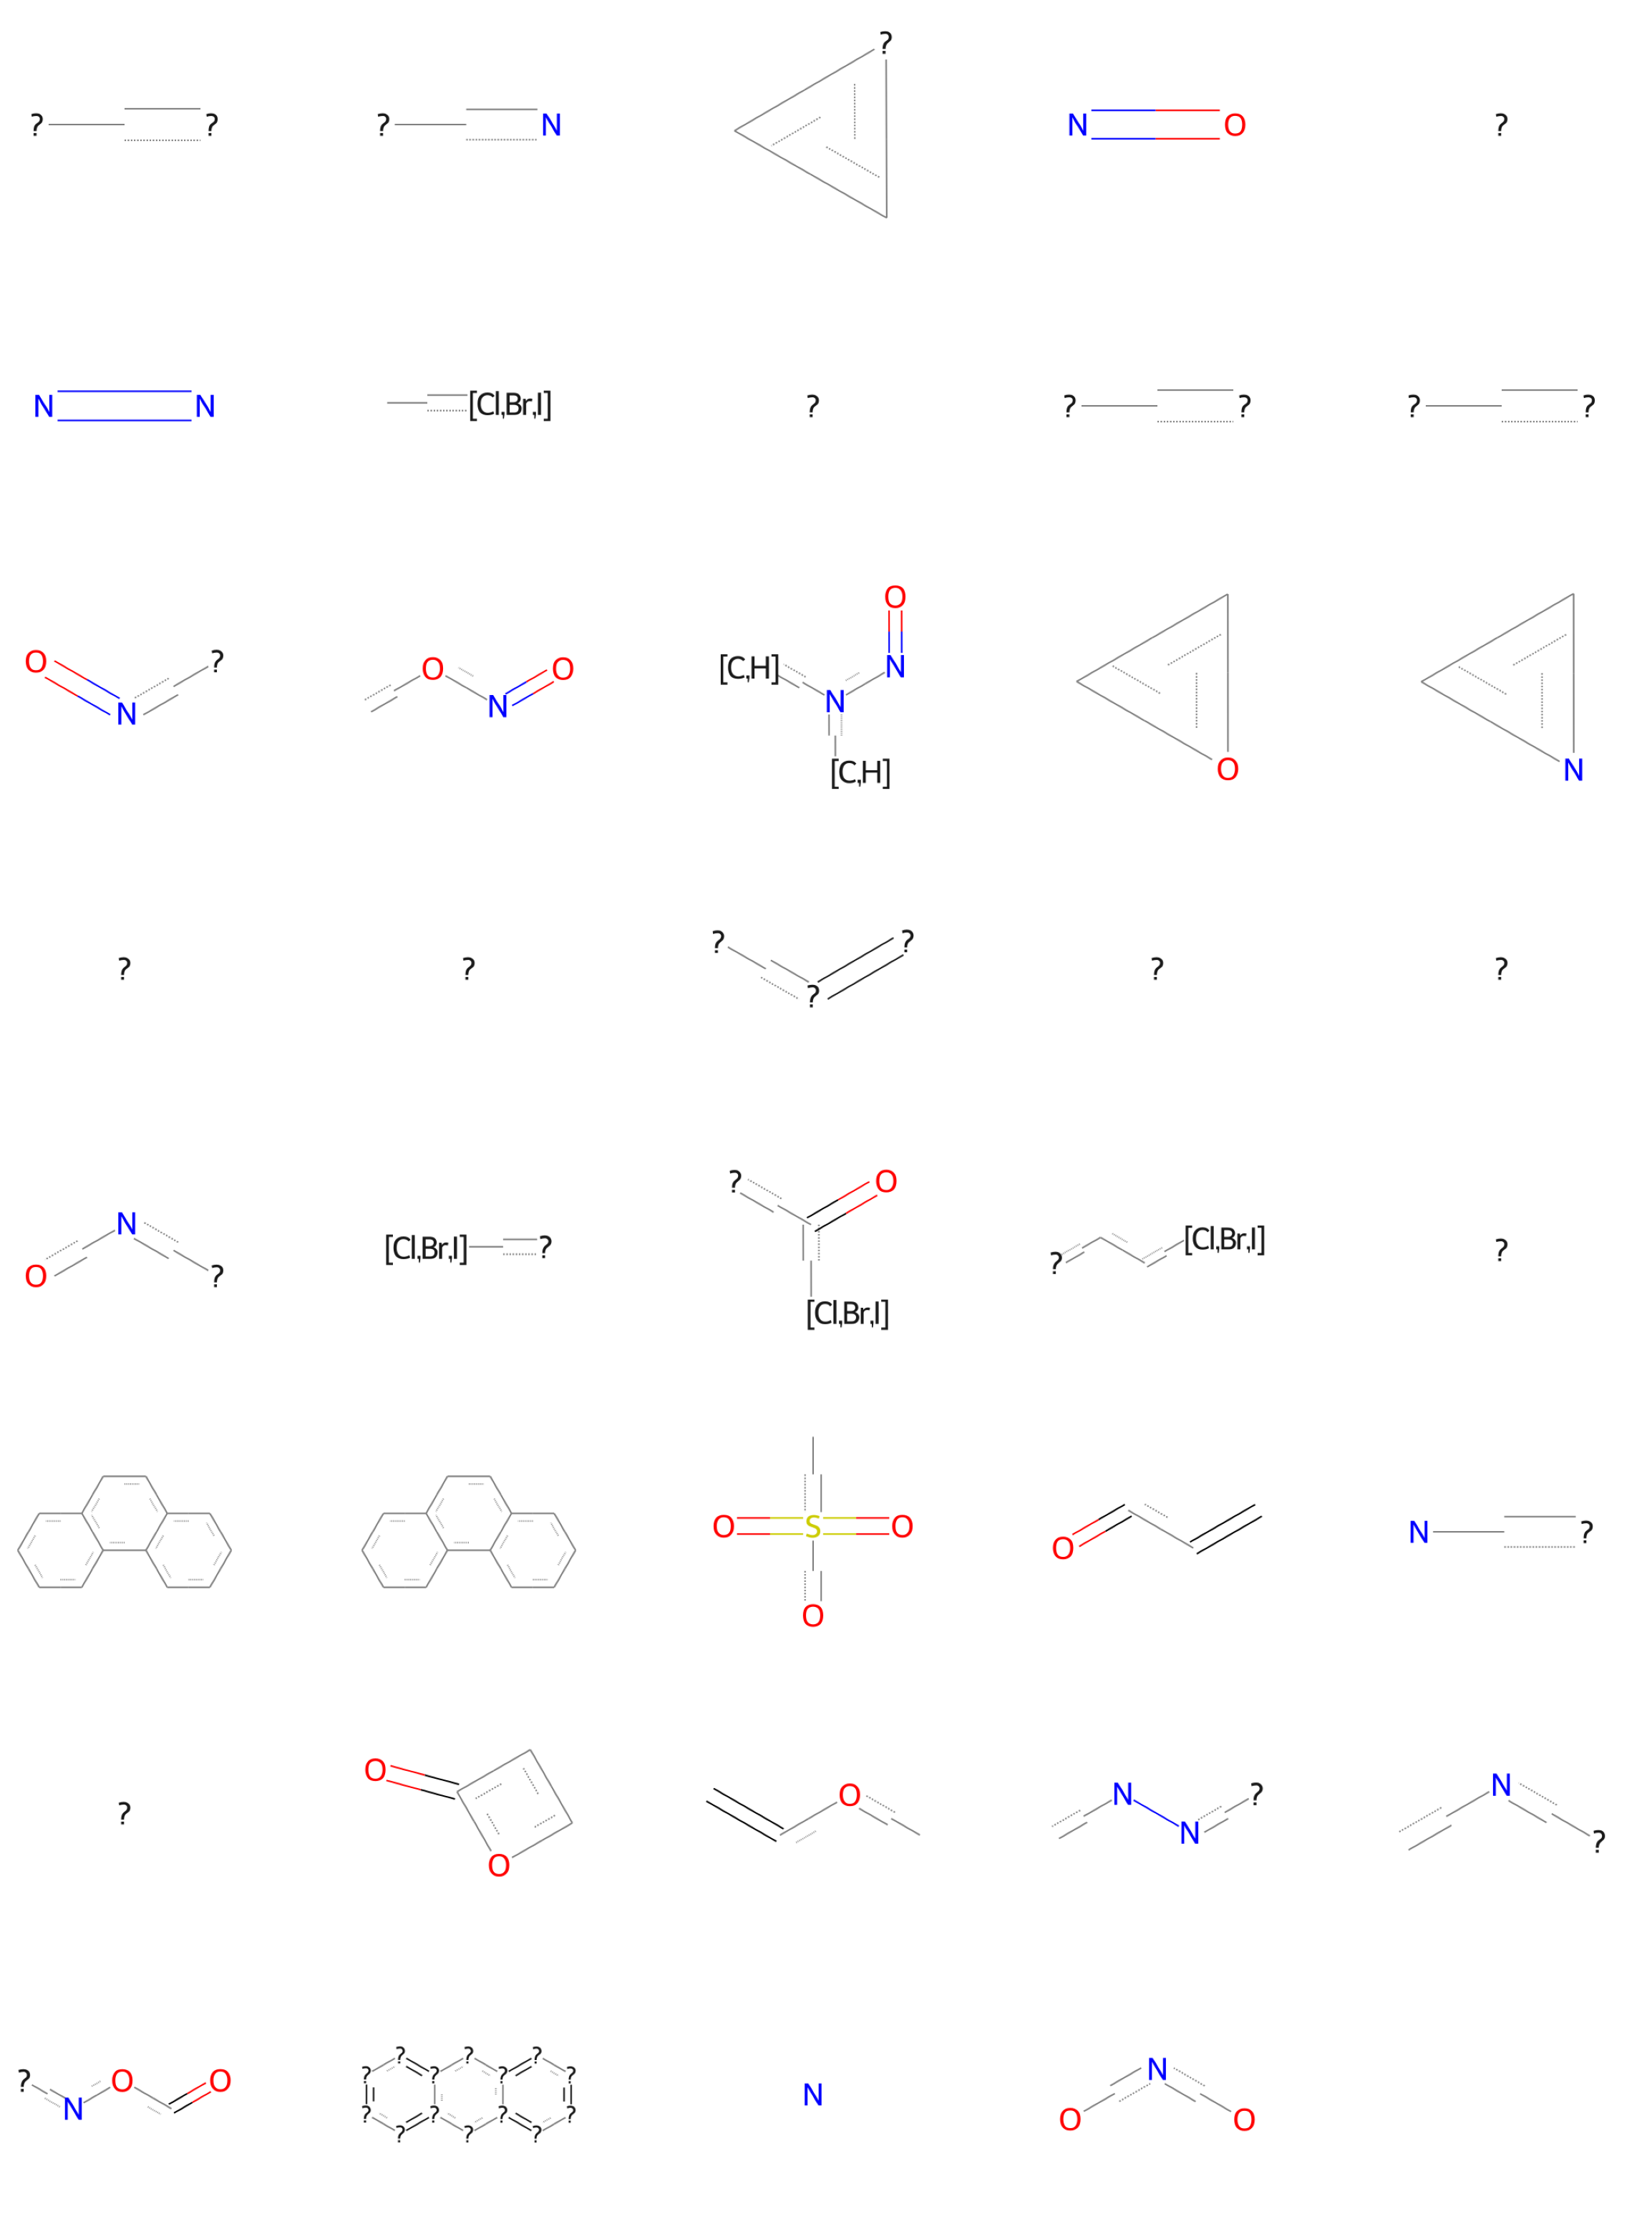

In [463]:
drawGridMolecule([Chem.MolFromSmarts(f) for f in reportedtest], labels=['' for f in reportedtest])

In [464]:
# try:
#     patt1 = Chem.MolFromSmarts(reportedtest[7])
#     display(patt1)
#     # patt2 = Chem.MolFromSmarts(f)
#     # smiles1 = Chem.MolFromSmiles(t)
#     smiles2 = Chem.MolFromSmiles(Final_Fragments_list[5])
#     display(smiles2)
#     print(smiles2.HasSubstructMatch(patt1))
# except Exception as e:
#     print(e)

In [465]:
# try:
#     patt1 = Chem.MolFromSmarts(reportedtest[7])
#     display(patt1)
#     patt2 = Chem.MolFromSmarts(Final_Fragments_list[5])
#     display(patt2)
#     patt2.UpdatePropertyCache()
#     # smiles1 = Chem.MolFromSmiles(t)
#     # smiles2 = Chem.MolFromSmiles(f)
#     print(patt1.HasSubstructMatch(patt2))
#     print(patt2.HasSubstructMatch(patt1))
# except Exception as e:
#     print(e)

# Matching

In [466]:
alert_match = list()
# for i, f in enumerate(list(sub_df['sub_list'])):
for i, f in enumerate(Final_Fragments_list):
    for t in reportedtest:
        try:
            patt1 = Chem.MolFromSmarts(t)
            # patt2 = Chem.MolFromSmarts(f)
            # smiles1 = Chem.MolFromSmiles(t)
            smiles2 = Chem.MolFromSmiles(f)
            match = smiles2.HasSubstructMatch(patt1)
            if match == True:
                alert_match.append([t, f, i])
                print('t in f',i, t, f)
                break
        except:
            pass

        try:
            patt1 = Chem.MolFromSmarts(t)
            patt2 = Chem.MolFromSmarts(f)
            patt2.UpdatePropertyCache()
            # smiles1 = Chem.MolFromSmiles(t)
            # smiles2 = Chem.MolFromSmiles(f)
            match = patt2.HasSubstructMatch(patt1)
            if match == True:
                alert_match.append([t, f, i])
                print('f in t', i, t, f)
                break
            match = patt1.HasSubstructMatch(patt2)
            if match == True:
                alert_match.append([t, f, i])
                print('t in f', i, t, f)
                break 
        except:
            pass

print('Result:')
print('- Reported structural patterns:', len(reportedtest))
print('- Final potential substructures:', len(Final_Fragments_list))
print('- Number of matches:', len(alert_match))
print('- Percentage of matches:', len(alert_match)/len(reportedtest), '%')

t in f 2 [N](O)(O) *~CON(~*)OC(=O)c1ccc(~*)cc1
t in f 3 [N](O)(O) *~C(=O)N(OCc1ccc(~*)cc1)OC(C)=O
t in f 4 [NX2]=[OX1] *~ON=O
t in f 5 [CX4][Cl,Br,I] *~SCCCl
t in f 6 [N](O)(O) *~CON(O~*)C(=O)c1ccc(~*)cc1
t in f 8 [NX2]=[NX2] *~CN=[N+]=[N-]
t in f 10 [CX4][Cl,Br,I] *~C(~*)C(Cl)(Cl)Cl
t in f 11 [CX4][Cl,Br,I] *~C(Cl)=CCl
t in f 12 [CX4][Sv6X4](=[OX1])(=[OX1])[OX2] *~S(O)(=O)=O
t in f 16 [NX2]=[OX1] *~N(~*)N=O
t in f 19 [$([NX3H2]-[#7]),$([NX3H2]-[#8]),$([OX2H1]-[#7]),$([OX2H1]-[#8])] *~c1ccc(N(O)C(C)=O)cc1
Result:
- Reported structural patterns: 39
- Final potential substructures: 20
- Number of matches: 11
- Percentage of matches: 0.28205128205128205 %


ID: 2
Structural Pattern: [N](O)(O)
Substructure: *~CON(~*)OC(=O)c1ccc(~*)cc1


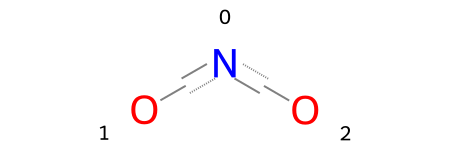

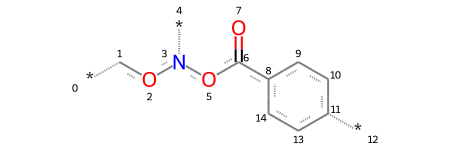

ID: 3
Structural Pattern: [N](O)(O)
Substructure: *~C(=O)N(OCc1ccc(~*)cc1)OC(C)=O


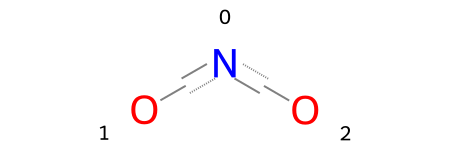

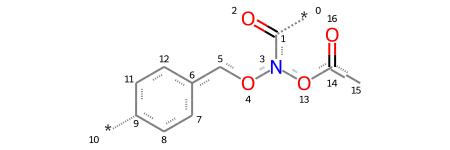

ID: 4
Structural Pattern: [NX2]=[OX1]
Substructure: *~ON=O


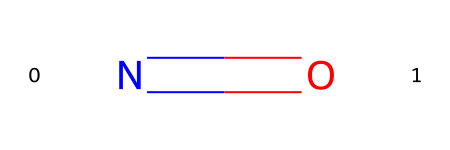

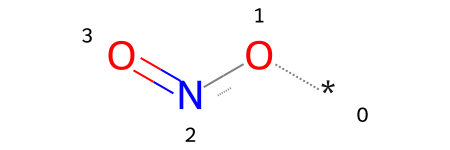

ID: 5
Structural Pattern: [CX4][Cl,Br,I]
Substructure: *~SCCCl


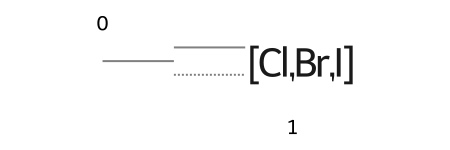

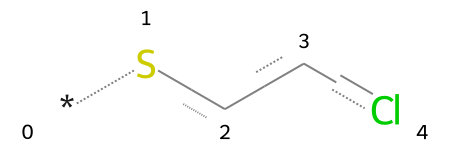

ID: 6
Structural Pattern: [N](O)(O)
Substructure: *~CON(O~*)C(=O)c1ccc(~*)cc1


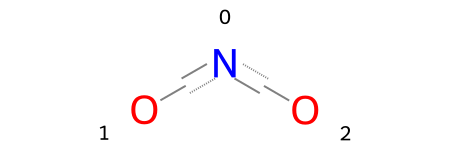

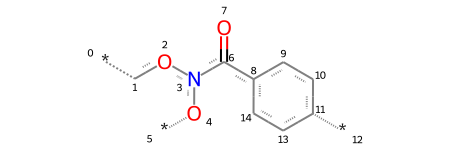

ID: 8
Structural Pattern: [NX2]=[NX2]
Substructure: *~CN=[N+]=[N-]


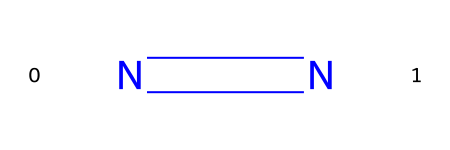

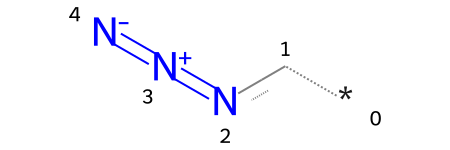

ID: 10
Structural Pattern: [CX4][Cl,Br,I]
Substructure: *~C(~*)C(Cl)(Cl)Cl


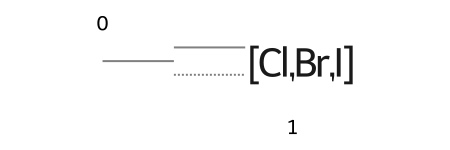

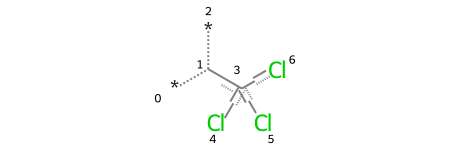

ID: 11
Structural Pattern: [CX4][Cl,Br,I]
Substructure: *~C(Cl)=CCl


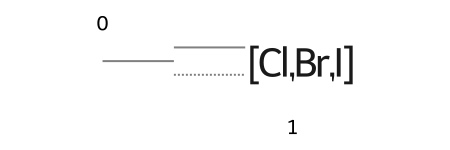

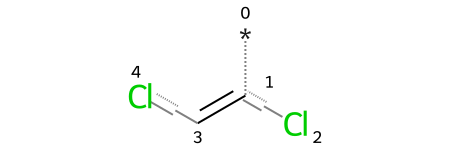

ID: 12
Structural Pattern: [CX4][Sv6X4](=[OX1])(=[OX1])[OX2]
Substructure: *~S(O)(=O)=O


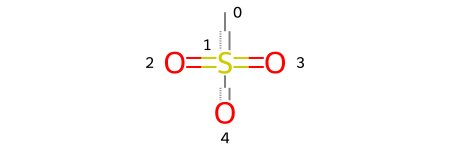

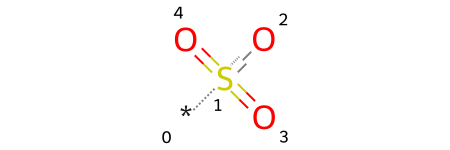

ID: 16
Structural Pattern: [NX2]=[OX1]
Substructure: *~N(~*)N=O


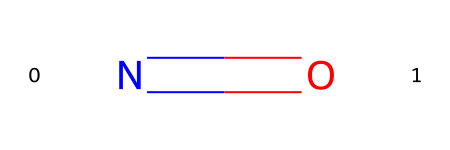

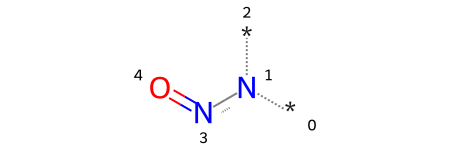

ID: 19
Structural Pattern: [$([NX3H2]-[#7]),$([NX3H2]-[#8]),$([OX2H1]-[#7]),$([OX2H1]-[#8])]
Substructure: *~c1ccc(N(O)C(C)=O)cc1


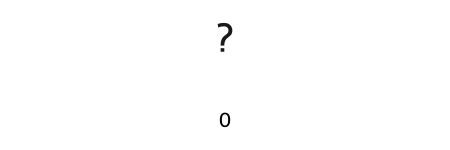

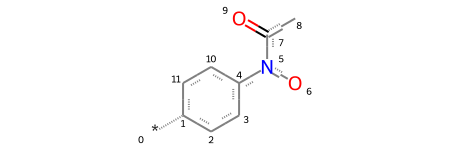

In [469]:
# print matches
for a in alert_match:
    print('ID:', a[2])
    print('Structural Pattern:', a[0])
    print('Substructure:', a[1])
    display(Chem.MolFromSmarts(a[0]))
    display(Chem.MolFromSmarts(a[1]))
    print('==============================================')

# Check Structural Patterns

In [470]:
sub_df['sub_list']

804          *~c1c[nH]cn1
3398        *~C=[N+]=[N-]
3172            *~C1NC1~*
304             *~N(O)N=O
1961              *~SCCBr
              ...        
71               *~C(C)=O
2816           *~C(~*)OCC
457             *~CCCCC~*
1263             *~CCCC~*
3227    *~C(~*)(~*)C(O)=O
Name: sub_list, Length: 3417, dtype: object

In [471]:
sub_df[sub_df['sub_list'] == '*~C(Br)Br']

sub_list  num_sub_passed  num_smiles_passed  num_sub_all  \
130  *~C(Br)Br               6                  6           13   

     num_smiles_all  percent_smiles_passed   fragment     score  
130              12                   50.0  *~C(Br)Br  0.068429

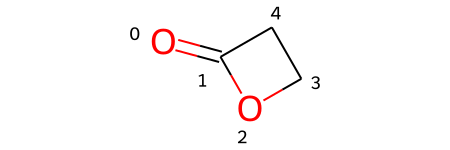

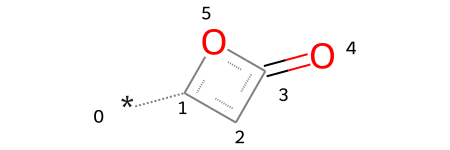

*~C1CC(=O)O1


In [472]:
test_sa = Chem.MolFromSmiles('O=C1OCC1')
display(test_sa)
# for s in sub_df['sub_list']:
for s in num_substructure[predicted]:
# for s in all_dataset:
    test_sub = Chem.MolFromSmarts(s)
    match = test_sub.HasSubstructMatch(test_sa)
    if match:
        display(test_sub)
        print(s)
        break